In [1]:
%load_ext autoreload
%autoreload 2

In [19]:
import sys, os
sys.path.append("../..")
sys.path.append("..")
sys.path.append(os.getcwd())
import re
import datetime

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import seaborn as sns
sns.set()
sns.set(palette="bright")
sns.set_style("whitegrid")

from sklearn import linear_model
from cycler import cycler
from celluloid import Camera

from IPython.display import HTML

import importlib

#importlib.reload(some_module)
import datetime as dt

import warnings

import numpy as np
import pandas as pd
import copy
import random


from tslib.src import tsUtils
from tslib.tests import testdata

#warnings.filterwarnings(action='once')

from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, DBSCAN #For clustering
from sklearn.mixture import GaussianMixture #For GMM clustering

from sklearn.metrics import mean_squared_error

import hdbscan
%matplotlib inline
from filter_data import *

from syn_model import *

In [3]:

#global settings for graphs        
cc = (cycler(linestyle=['-', '--', '-.',':']) * cycler(color=list('brgcmyk')))
plt.rc('lines', linewidth=2)
plt.rc('axes', prop_cycle=cc)
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = (8.0, 6.0)

plt.rcParams["animation.html"] = "html5"

In [4]:
from load_and_clean import *

#update_data()

#us = load_clean('NYTimes US')
uscases, usdeaths, usstates = load_clean('NYTimes states')
uscounties_cases, uscounties_deaths, uscounties = load_clean('NYTimes counties')
global_cases, global_deaths = load_clean('JHU global')
us_covid_jhu_cases, us_covid_jhu_deaths = load_clean('JHU US')
mobility_data_apple = load_clean('mobility Apple')
mobility_data_google, google_social = load_clean('mobility Google')
sd_data = load_clean('IHME intervention')
all_population, us_population, usstates_population, uscounties_population = load_clean('population')

uscases_pop_adjusted, usdeaths_pop_adjusted = create_population_adjusted_data(uscases, all_population), \
                                    create_population_adjusted_data(usdeaths, all_population, show_exception = True)
global_cases_pop_adjusted, global_deaths_pop_adjusted = create_population_adjusted_data(global_cases, all_population), \
                                    create_population_adjusted_data(global_deaths, all_population, show_exception = True)

uscounties_cases_pop_adjusted = create_population_adjusted_data(uscounties_cases, all_population, show_exception = True, county = True)
uscounties_deaths_pop_adjusted = create_population_adjusted_data(uscounties_deaths, all_population, county = True)

state_reopen = load_clean('state reopen')
#fips_df = pd.read_csv("../COVID/COVID-19/csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv")

ctp_us_data = load_clean('CTP US')
ctp_state_data = load_clean('CTP states')
ctp_state_pop_adjusted = {stat: create_population_adjusted_data(data, all_population, show_exception=False) for stat, data in ctp_state_data.items()}

Unable to update Google mobility data (5888)
Unable to update Apple mobility data
Unable to update CTP US data (copy: 256)
Unable to update CTP state data (copy: 256)


These countries/region do not have population data ['Virgin Islands']
These countries/region do not have population data ['Bahamas', 'Burma', 'Cabo Verde', 'Congo (Brazzaville)', 'Congo (Kinshasa)', "Cote d'Ivoire", 'Diamond Princess', 'Eswatini', 'Gambia', 'Holy See', 'Kyrgyzstan', 'MS Zaandam', 'North Macedonia', 'Saint Kitts and Nevis', 'Saint Lucia', 'Saint Vincent and the Grenadines', 'Slovakia', 'Syria', 'Taiwan*', 'West Bank and Gaza', 'Western Sahara']
These countries/region do not have population data ['Adjuntas-Puerto Rico', 'Aguada-Puerto Rico', 'Aguadilla-Puerto Rico', 'Aguas Buenas-Puerto Rico', 'Aibonito-Puerto Rico', 'Anasco-Puerto Rico', 'Anchorage-Alaska', 'Arecibo-Puerto Rico', 'Arroyo-Puerto Rico', 'Barceloneta-Puerto Rico', 'Barranquitas-Puerto Rico', 'Bayamon-Puerto Rico', 'Cabo Rojo-Puerto Rico', 'Caguas-Puerto Rico', 'Camuy-Puerto Rico', 'Canovanas-Puerto Rico', 'Carolina-Puerto Rico', 'Catano-Puerto Rico', 'Cayey-Puerto Rico', 'Ceiba-Puerto Rico', 'Ciales-Puerto

In [5]:
#Filter data (this part might be overlapping some cells, but it should contain most of the varilables that are analyzed. )
# This part might be to split and explain
# This part might be to split and explain
t = 7
column = list(mobility_data_google.columns).index('retail_and_recreation_percent_change_from_baseline')
global_deaths_filtered = create_filtered_data(global_deaths, 500 )
#the last column of social distancing dataset is the last social distancing measure used by a location
educational_distancing = get_social_distancing(sd_data, sd_data.columns[-1])

all_data = pd.concat([global_deaths, usdeaths, uscounties_deaths], axis=1).dropna()
all_data_daily = create_rolling_data(all_data, t)

all_data_cases = pd.concat([global_cases, uscases, uscounties_cases], axis=1).dropna()
all_data_cases_daily = create_rolling_data(all_data_cases, t)

all_cases_data_pop = pd.concat([uscases_pop_adjusted,global_cases_pop_adjusted, uscounties_cases_pop_adjusted], axis = 1).dropna()
all_cases_data_pop_daily = create_rolling_data(all_cases_data_pop, t)

all_death_data_pop = pd.concat([usdeaths_pop_adjusted,global_deaths_pop_adjusted, uscounties_deaths_pop_adjusted], axis = 1).dropna()
all_death_data_pop_daily = create_rolling_data(all_death_data_pop, t)

_, daily_global, intervention_date_global = create_intervention_adjusted_data(global_deaths, educational_distancing, t)
_, daily_us, intervention_date_us = create_intervention_adjusted_data(usdeaths, educational_distancing, t)
_, daily_uscounties, intervention_date_uscounties = create_intervention_adjusted_data(uscounties_deaths, educational_distancing, t)

cases_intervention_adjusted, cases_intervention_adjusted_daily, intervention_date_case = create_intervention_adjusted_data(all_data_cases, educational_distancing, t)
deaths_intervention_adjusted, deaths_intervention_adjusted_daily, intervention_date_death = create_intervention_adjusted_data(all_data, educational_distancing, t)
#deaths_intervention_adjusted_google, deaths_intervention_adjusted_daily_google, _ = create_intervention_adjusted_data(all_data, google_social, t)

all_cases_data_pop_adjusted, all_cases_data_pop_adjusted_daily, _ = create_intervention_adjusted_data(all_cases_data_pop, educational_distancing, t)
all_death_data_pop_adjusted, all_death_data_pop_adjusted_daily, _ = create_intervention_adjusted_data(all_death_data_pop, educational_distancing, t)

hospitalized_pop_adjusted, hospitalized_pop_adjusted_daily, _ = create_intervention_adjusted_data(ctp_state_pop_adjusted['hospitalizedCurrently'], educational_distancing, t, ignore_nan=True)
icu_pop_adjusted, icu_pop_adjusted_daily, _ = create_intervention_adjusted_data(ctp_state_pop_adjusted['inIcuCurrently'], educational_distancing, t, ignore_nan=True)
ventilator_pop_adjusted, icu_pop_adjusted_daily, _ = create_intervention_adjusted_data(ctp_state_pop_adjusted['onVentilatorCurrently'], educational_distancing, t, ignore_nan=True)


last date
Exceptions are []


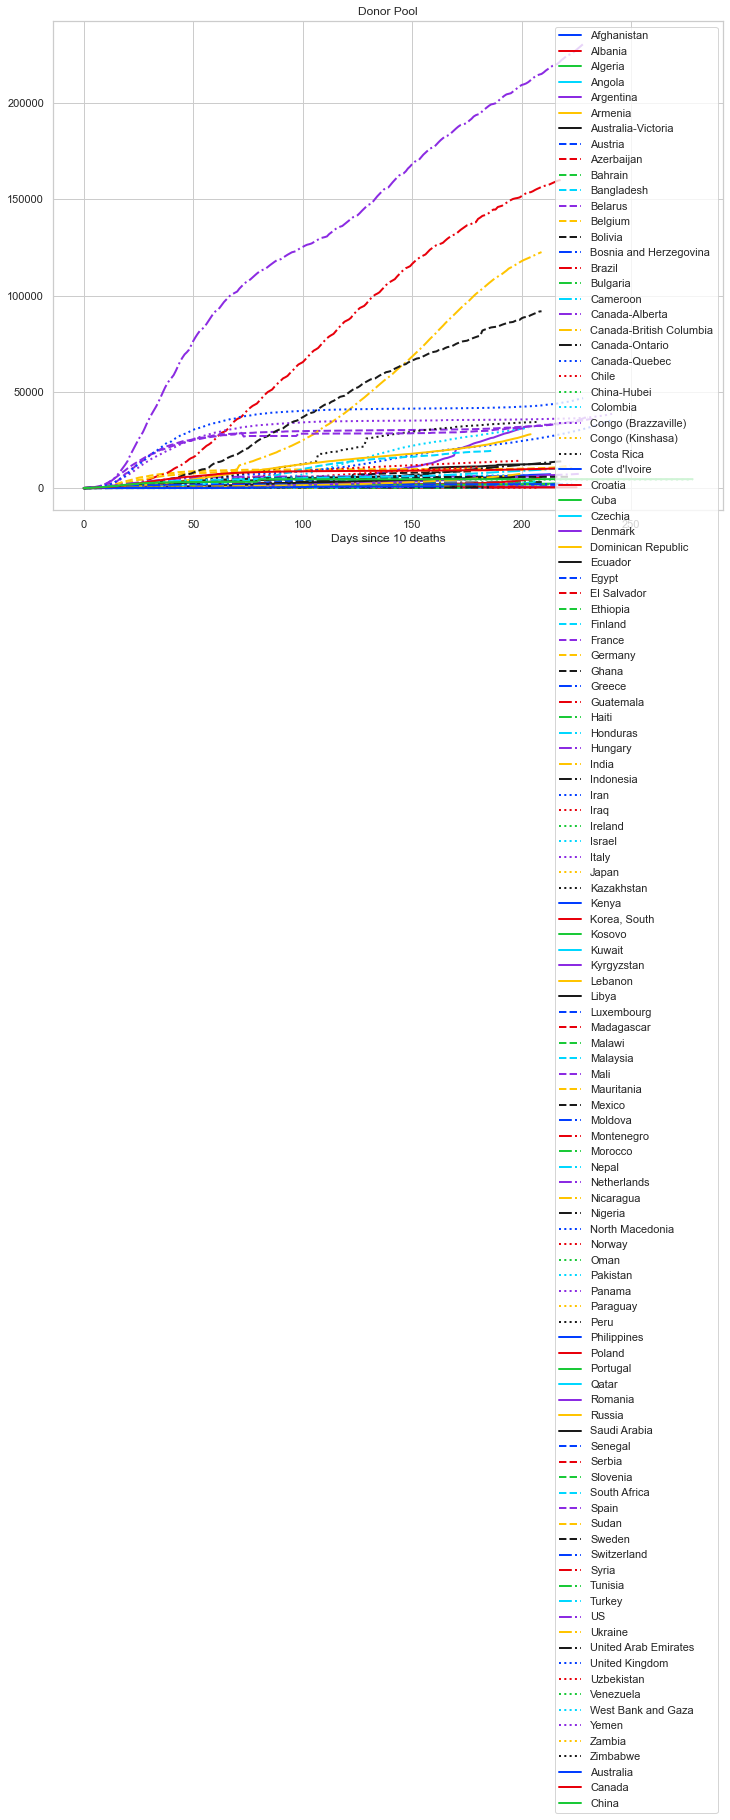

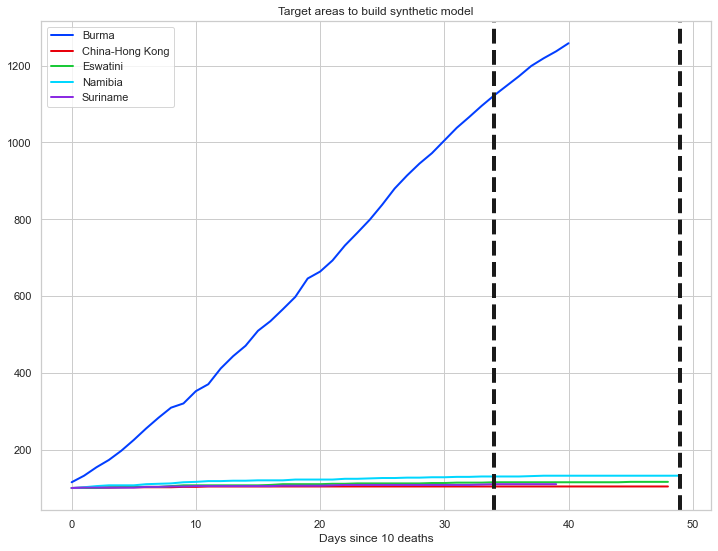

In [6]:
plt.rcParams['figure.figsize'] = (12.0, 9.0)
plt.rcParams.update({'font.size': 8})

global_deaths_filtered = create_filtered_data(global_deaths, 100 )

sizes = global_deaths_filtered.apply(pd.Series.last_valid_index)
  
low_thresh=35
threshold=50
donorlpool = list(sizes[sizes>threshold].index)

global_deaths_filtered[donorlpool].plot( grid=True, title='Donor Pool', linewidth=2)
plt.xlabel('Days since 10 deaths')
plt.show()

prediction_states = list(sizes[(sizes>low_thresh) & (sizes<threshold)].index)
global_deaths_filtered[prediction_states].plot(grid=True, title='Target areas to build synthetic model', linewidth=2)
plt.xlabel('Days since 10 deaths')
plt.axvline(x=low_thresh-1, color='k', linestyle='--', linewidth=4)
plt.axvline(x=threshold-1, color='k', linestyle='--', linewidth=4)


plt.show()


((array([-50.,   0.,  50., 100., 150., 200., 250., 300.]),
  [Text(0, 0, ''),
   Text(0, 0, ''),
   Text(0, 0, ''),
   Text(0, 0, ''),
   Text(0, 0, ''),
   Text(0, 0, ''),
   Text(0, 0, ''),
   Text(0, 0, '')]),
 (array([-50000.,      0.,  50000., 100000., 150000., 200000., 250000.]),
  [Text(0, 0, ''),
   Text(0, 0, ''),
   Text(0, 0, ''),
   Text(0, 0, ''),
   Text(0, 0, ''),
   Text(0, 0, ''),
   Text(0, 0, '')]))

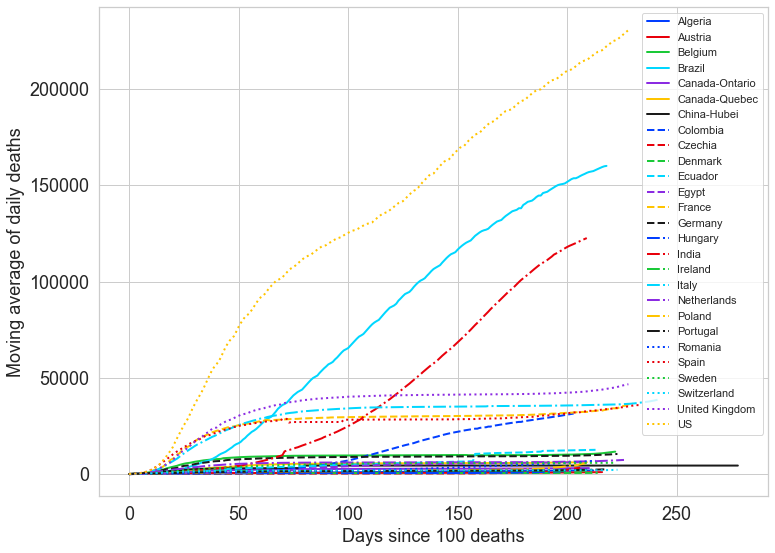

In [7]:

FONTSIZE = 18
fig, ax = plt.subplots()

group = ['Algeria','Austria', 'Belgium', 'Brazil','Canada-Ontario','Canada-Quebec','China-Hubei','Colombia', 'Czechia', 'Denmark','Ecuador','Egypt','France', 'Germany', 'Hungary', 'India', 'Ireland', 'Italy', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Spain', 'Sweden', 'Switzerland', 'United Kingdom','US']

plt.rcParams['figure.figsize'] = (12.0, 8.0)
#plt.xlim([0,60])
global_deaths_filtered[group].plot(ax = ax,grid=True), plt.legend(), plt.xlabel('Days since 100 deaths', fontsize = FONTSIZE), plt.ylabel('Moving average of daily deaths', fontsize = FONTSIZE)
plt.xticks(fontsize = FONTSIZE), plt.yticks(fontsize = FONTSIZE)


#plt.savefig('../Figures/COVID/aligned_100deaths.pdf', bbox_inches='tight')




In [8]:
rolling_average_duration = 7

daily_global_raw = create_rolling_data(create_filtered_data(global_deaths,5),rolling_average_duration)

daily_us_raw = create_rolling_data(create_filtered_data(usdeaths,5),rolling_average_duration)
daily_uscounties_raw = create_rolling_data(create_filtered_data(uscounties_deaths,5),rolling_average_duration)


In [9]:
from get_social_distancing import *
print(sd_data.columns)
intervention_tried = sd_data.columns[7]


Index(['name', 'country', 'admin1', 'Mass gathering restrictions',
       'Stay at Home Order', 'Educational facilities closed',
       'Initial business closures', 'Non-essential services closed',
       'Travel severely limited', 'Source Mass gathering restrictions',
       'Source Stay at Home Order', 'Source Educational facilities closed',
       'Source Initial business closure',
       'Source Non-essential services closed',
       'Source Travel severely limited', 'last date'],
      dtype='object')


In [10]:
educational_distancing = get_social_distancing(sd_data, sd_data.columns[-1])

last date
Exceptions are []


In [11]:

all_data = pd.concat([global_deaths, usdeaths], axis=1)  
all_data = pd.concat([all_data, uscounties_deaths], axis=1)

all_data_daily = create_rolling_data(all_data)
all_data_cases = pd.concat([global_cases, uscases], axis=1) 

all_data_cases = pd.concat([all_data_cases, uscounties_cases], axis=1)


all_data_cases_daily =create_rolling_data(all_data_cases)

In [12]:
newdf, _=filter_data_by_intervention(usdeaths, educational_distancing)
newdf_global,_=filter_data_by_intervention(global_deaths, educational_distancing)
newdf_uscounties,_=filter_data_by_intervention(uscounties_deaths, educational_distancing)

New York -1 31967.992065812872
New York -2 9667.813213952968
New York -3 2192.9525326485145
New York -4 1009.8399157124572
New York -5 475.5718204019506
New York -6 290.11962100088965
New York -7 145.98170249262313
New York -8 146.09318348933908
New York -9 167.98282629479388


RuntimeError: Requested MovieWriter (ffmpeg) not available

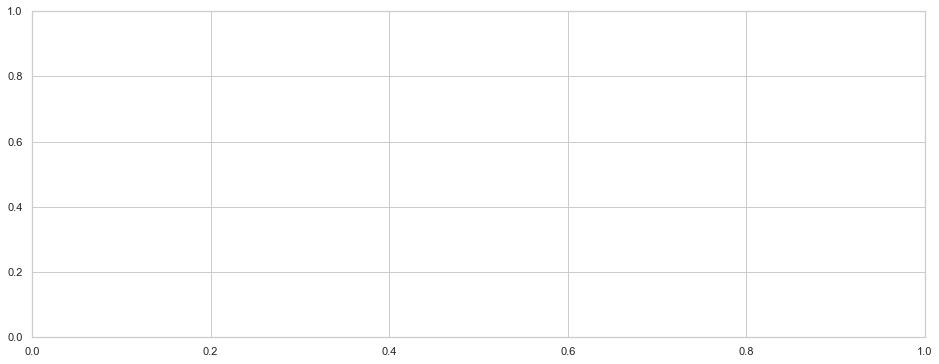

In [13]:

targets = ['New York', 'Italy', 'Spain', 'United Kingdom', 'France']


test, _ = filter_data_by_intervention(all_data_daily[targets], educational_distancing, 1)

singVals = 5

    

videos = []
for target in targets:
    fig, axes = plt.subplots(figsize=(16, 6))
    camera = Camera(fig)
    
    for i in range(1,10):
        temp_df,_= filter_data_by_intervention(all_data_daily[[target]], educational_distancing, i)

        # This has been made silent as to not flood the output
        return_value = synth_control_predictions([pd.concat([deaths_intervention_adjusted_daily,temp_df], axis=1)], 42,22, "5-day moving average of daily deaths", singVals, ylimit=[], 
                                   savePlots=False, do_only=[target+" -%s"%i], showstates=12,
                                   exclude=[target], animation=camera, figure=fig, axes=axes, showDonors=False, silent=True, showPlots=True)
    

    animation = camera.animate()
    videos.append(HTML(animation.to_html5_video()))

    
    #HTML(animation_final.to_jshtml())

    #animation_final.save('../animations/'+target+' no donors new.mp4')
display(*videos)

In [ ]:
# plot what would have happened had the lockdown started 10 days earlier 

targets = ['New York']#, 'Italy', 'Spain', 'United Kingdom', 'France']

test, _ = filter_data_by_intervention(all_data_daily[targets], educational_distancing, 1)

singVals = 5
#lambdas = [1, 50]
#dist = lambda s: np.random.normal(0, 100, s)



videos = []
for target in targets:
    
    #camera = Camera(fig)
    
    i = 10
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    temp_df,_= filter_data_by_intervention(all_data_daily[[target]], educational_distancing, i)

    # This has been made silent as to not flood the output
    return_value = synth_control_predictions([pd.concat([deaths_intervention_adjusted_daily,temp_df], axis=1)], 42,22, "5-day moving average of daily cases", singVals, ylimit=[], 
                               savePlots=False, do_only=[target+" -%s"%i], showstates=10,
                               exclude=[target], figure=fig, axes=axes, donorPool=['Italy', 'United Kingdom', 'France', 'Spain', 'Germany', 'Netherlands', 'Belgium', 'Switzerland'], 
                               svdSpectrum=False, silent=True, showDonors=True, showPlots=True,  mRSC=False, error_thresh = 10)#lambdas=lambdas, random_distribution=dist



    #newdata = synth_control_predictions([df1, df],projection_period, training_period, 
    #                                   "Cases Data", 2, ylimit=[], savePlots=False, do_only=['New York'], showstates=10,
    #                       exclude=[target], figure=fig, axes=axes, donorPool=['Italy', 'United Kingdom', 'France', 'Spain', 'Germany', 'Netherlands', 'Belgium', 'Switzerland'], 
    #                            svdSpectrum=False, silent=True, showDonors=True, showPlots=True, lambdas=lambdas, mRSC=False, error_thresh = 10, random_distribution=dist)
    #videos.append(HTML(animation.to_html5_video()))

    
    #HTML(animation_final.to_jshtml())

    #animation_final.save('../animations/'+target+' no donors new.mp4')
#display(*videos)


In [ ]:
targets = ['New York', 'Illinois', 'New York', 'Illinois', 'Belgium', 'Switzerland', 'New Jersey', 'France', 'Italy', 'United Kingdom']# 'Ohio', 'Sweden']
donorpool = ['Italy', 'Spain', 'France', 'China-Hubei']
singVals = 2

move_intervention = 10
videos = []
for target in targets:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    camera = Camera(fig)
    for i in range(1,10):
        # This has been made silent as to not flood the output
        new_value = synth_control_predictions([deaths_intervention_adjusted_daily],40,2+i, "Deaths Data", singVals, ylimit=[], savePlots=False, do_only=[target], showstates=10,
                               exclude=[], svdSpectrum=False, donorPool=donorpool, animation=camera, figure=fig, axes=axes, showDonors=True, silent=True )
    animation = camera.animate(interval=300)
    videos.append(HTML(animation.to_html5_video()))
#animation.save('../animations/'+target+' predictions.mp4')
#temp_df = filter_data_by_intervention(all_data_daily[[target]], educational_distancing, move_intervention)
        #synth_control_predictions(pd.concat([deaths_intervention_adjusted_daily,temp_df], axis=1),45,25, "Deaths Data", 
                              #singVals, ylimit=[], savePlots=False, do_only=[target+" -"+str(move_intervention)], 
                              # showstates=10, svdSpectrum=False, showDonors=False,
                              # exclude=[target])
display(*videos)

In [ ]:
df = deaths_intervention_adjusted_daily
df = df[df.columns[(df>10).any()]].copy()
lambdas=[1,0.01]
df1 = cases_intervention_adjusted_daily[df.columns].iloc[15:,:].copy()

#targets = [ 'New York', 'Illinois', 'Belgium', 'Switzerland', 'New Jersey', 'France', 'Italy', 'United Kingdom']# 'Ohio', 'Sweden']
#targets = newdf.columns
high_thresh = 55
low_thresh = 50
#targets = random.sample(list(deaths_intervention_adjusted_daily.columns),80)
targets = df.columns
sizes = df[targets].apply(pd.Series.last_valid_index)
targets = sizes[sizes>=low_thresh].index


donorpool = sizes[sizes>=high_thresh].index


print(targets)
print(donorpool)
singVals = 3
weight_features = []
move_intervention = 10
for target in targets:
  
    try:
        newdata = synth_control_predictions([df, df1],high_thresh, low_thresh,
                                            "Deaths Data", singVals, ylimit=[], savePlots=False, do_only=[target], showstates=10,
                               exclude=[], svdSpectrum=False, silent=True, showDonors=False, showPlots=False, lambdas=lambdas, mRSC=False, error_thresh = 1)
        weight_features.append(newdata)
    except ValueError:
        print(target)
        continue
feature_list = pd.DataFrame((weight_features))
feature_list.index=targets
feature_list.fillna(0, inplace=True)
#feature_list = feature_list.apply(lambda x: x/x.max(), axis=1)
feature_columns = feature_list.columns
kmeans = KMeans(n_clusters=5)
y = kmeans.fit_predict(feature_list[feature_columns])
feature_list.insert((feature_list.shape[1]),'KMeans',y)
feature_list.groupby('KMeans').groups
clusterer = hdbscan.HDBSCAN(min_cluster_size=2, cluster_selection_method='leaf')
clustering_labels = clusterer.fit_predict(feature_list[feature_columns])
feature_list['DB'] = clustering_labels
feature_list.groupby('DB').groups


In [ ]:
num_groups = len(feature_list.groupby('DB').groups)
plt.rcParams.update({'font.size': 8})
plt.rcParams['figure.figsize'] = (20.0, num_groups*6.0)
group1 = list(feature_list.groupby('DB').groups[-1])
for i in range(num_groups):
    group = (list(feature_list.groupby('DB').groups[i-1]))
    ax = plt.subplot(num_groups,2,2*i+1)

    df[group].plot(ax = ax, xlim=[0,60]), plt.legend(), plt.xlabel('Days since lockdown'), plt.ylabel('Moving average of daily deaths')
    ax = plt.subplot(num_groups,2,2*i+2)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(15))
    all_data_daily[group].loc['2020-03-02':,:].plot(ax = ax), plt.legend(), plt.xlabel('Chronological Date'), plt.ylabel('Moving average of daily deaths')

In [ ]:
plt.rcParams['figure.figsize'] = (12,9.0)
plt.rcParams.update({'font.size': 12})


targets = ['Connecticut', 'Sweden', 'California', 'Michigan', 'Netherlands', 'Ohio', 'Indiana']
deaths_intervention_adjusted_daily[targets].plot()

In [ ]:
plt.rcParams['figure.figsize'] = (20,9.0)

group=['India']
ax = plt.subplot(1,2,1)

df[group].plot(ax = ax, xlim=[0,60]), plt.legend(), plt.xlabel('Days since lockdown'), plt.ylabel('Moving average of daily deaths')
ax = plt.subplot(1,2,2)
ax.xaxis.set_major_locator(ticker.MultipleLocator(15))
all_data_daily[group].loc['2020-03-02':,:].plot(ax = ax), plt.legend(), plt.xlabel('Chronological Date'), plt.ylabel('Moving average of daily deaths')

In [ ]:
clusters = []
epsilon_range = np.arange(0.005,3,0.01)
for epsilon in epsilon_range:
    clustering = DBSCAN(eps=epsilon, min_samples=4).fit(feature_list[feature_columns].values)
    clusters.append(len(np.unique(clustering.labels_)))
plt.rcParams['figure.figsize'] = (8, 6)
plt.plot(epsilon_range, clusters)

eps = epsilon_range[np.argmax(clusters)]
eps = epsilon_range[random.choice(np.argwhere(clusters == np.amax(clusters)))]
print(eps)
#eps=.28
clustering = DBSCAN(eps=eps, min_samples=4).fit(feature_list[feature_columns].values)    
try:
    feature_list['DB'] = clustering.labels_
except KeyError:
    feature_list.insert((feature_list.shape[1]),'DB',clustering.labels_)
feature_list.groupby('DB').groups

In [ ]:
plt.rcParams.update({'font.size': 14})
list_of_clusters = ['Austria', 'Michigan', 'Sweden', 'Connecticut', 'Maryland', 'California', 'New York']
num_clusters = len(list_of_clusters)
plt.rcParams['figure.figsize'] = (8.0, num_clusters*6.0)

i=1
for clusters in list_of_clusters:
    ax = plt.subplot(num_clusters,1,i)
    deaths_intervention_adjusted_daily[clusters].plot(ax=ax), plt.xlabel('Days Since Lockdown'), plt.ylabel('Moving Average Daily Deaths'), 
    cases_intervention_adjusted_daily[clusters].plot(ax=ax, linestyle=":", secondary_y=True), plt.ylabel('Moving Average Daily Cases'), plt.legend(),
    plt.xticks(rotation=45)
    i = i+1
                                                                                                

In [ ]:
plt.rcParams['figure.figsize'] = (24.0, 12.0)
ax = plt.subplot(4,2,1)

deaths_intervention_adjusted_daily[['Connecticut', 'Sweden', 'California' ]].plot(ax=ax), plt.xlim(0,60),

plt.xticks(rotation=45), plt.xlabel('Days Since Lockdown'), plt.ylabel('Moving Average Daily Deaths')

ax = plt.subplot(4,2,2)

deaths_intervention_adjusted_daily[['Michigan', 'Netherlands']].plot(ax=ax), plt.xlim(0,60),

plt.xticks(rotation=45), plt.xlabel('Days Since Lockdown'), plt.ylabel('Moving Average Daily Deaths')

ax = plt.subplot(4,2,3)
deaths_intervention_adjusted_daily[['Austria', 'Czechia', 'Denmark', 'Hungary','Wisconsin']].plot(ax=ax), plt.xlim(0,60),

#deaths_intervention_adjusted_daily[['Ireland', 'Colorado']].plot(ax=ax), 

plt.xticks(rotation=45), plt.xlabel('Days Since Lockdown'), plt.ylabel('Moving Average Daily Deaths')

ax = plt.subplot(4,2,4)

deaths_intervention_adjusted_daily[['Ohio', 'Los Angeles-California', 'Indiana']].plot(ax=ax), plt.xlim(0,60),

plt.xticks(rotation=45), plt.xlabel('Days Since Lockdown'), plt.ylabel('Moving Average Daily Deaths')

plt.plot()
ax = plt.subplot(4,2,5)

deaths_intervention_adjusted_daily[['Alabama', 'Mississippi', 'Missouri' ]].plot(ax=ax), plt.xlim(0,60),

plt.xticks(rotation=45), plt.xlabel('Days Since Lockdown'), plt.ylabel('Moving Average Daily Deaths')

ax = plt.subplot(4,2,6)

deaths_intervention_adjusted_daily[['District of Columbia', 'Iowa']].plot(ax=ax), plt.xlim(0,60),

plt.xticks(rotation=45), plt.xlabel('Days Since Lockdown'), plt.ylabel('Moving Average Daily Deaths')

ax = plt.subplot(4,2,7)

deaths_intervention_adjusted_daily[['Georgia', 'Texas']].plot(ax=ax), plt.xlim(0,60),

plt.xticks(rotation=45), plt.xlabel('Days Since Lockdown'), plt.ylabel('Moving Average Daily Deaths')

ax = plt.subplot(4,2,8)

deaths_intervention_adjusted_daily[[ 'United Kingdom', 'New York', 'Italy', 'Spain']].plot(ax=ax), plt.xlim(0,60),

plt.xticks(rotation=45), plt.xlabel('Days Since Lockdown'), plt.ylabel('Moving Average Daily Deaths')

In [ ]:
plt.rcParams['figure.figsize'] = (16.0, 12.0)
ax = plt.subplot(2,2,1)

deaths_intervention_adjusted_daily[['Connecticut', 'Sweden', 'California' ]].plot(ax=ax), plt.grid(),
plt.xticks(rotation=45), plt.xlabel('Days Since Lockdown'), plt.ylabel('Moving Average Daily Deaths')

ax = plt.subplot(2,2,2)

deaths_intervention_adjusted_daily[['Michigan', 'Netherlands']].plot(ax=ax), plt.grid(), 
plt.xticks(rotation=45), plt.xlabel('Days Since Lockdown'), plt.ylabel('Moving Average Daily Deaths')

ax = plt.subplot(2,2,3)

deaths_intervention_adjusted_daily[['Ireland', 'Colorado']].plot(ax=ax), plt.grid(), 
plt.xticks(rotation=45), plt.xlabel('Days Since Lockdown'), plt.ylabel('Moving Average Daily Deaths')

ax = plt.subplot(2,2,4)

deaths_intervention_adjusted_daily[['Ohio', 'Los Angeles-California', 'Indiana']].plot(ax=ax), plt.grid(), 
plt.xticks(rotation=45), plt.xlabel('Days Since Lockdown'), plt.ylabel('Moving Average Daily Deaths')

In [ ]:
plt.rcParams.update({'font.size': 10})
plt.rcParams['figure.figsize'] = (20.0, 24.0)
plt.xlim([0,60])
for i in range(len(feature_list.groupby('DB').groups)):
    ax = plt.subplot(3,2,i+1)
    plt.xlim([0,60])
    group = (list(feature_list.groupby('DB').groups[i-1]))
    print(group)
    df[group].plot(ax = ax), plt.legend(), plt.xlabel('Days since lockdown'), plt.ylabel('Moving average of daily deaths'),plt.grid()

In [ ]:
states = list(set(usstates['state'].values))
print(states)

In [ ]:
high_thresh = 40
low_thresh = 35
targets = usstates
#excludelist = group2.copy()

sizes = deaths_intervention_adjusted_daily[targets].apply(pd.Series.last_valid_index)
targets = sizes[sizes>low_thresh].index
donorpool = sizes[sizes>high_thresh].index
print(targets)
print(donorpool)
singVals = 3
weight_features = []
move_intervention = 10
for target in targets:
  
    try:
        newdata = synth_control_predictions([deaths_intervention_adjusted_daily[targets]],high_thresh, low_thresh,
                                            "Daily Deaths Data", singVals, ylimit=[], savePlots=False, do_only=[target], showstates=10,
                              svdSpectrum=False, silent=True, showDonors=False, mRSC=False, showPlots=False)
        #newdata = synth_control_predictions(deaths_intervention_adjusted_daily,high_thresh, low_thresh,
        #                                    "Deaths Data", singVals, ylimit=[], savePlots=False, do_only=[target], showstates=10,
        #                       exclude=excludelist, svdSpectrum=False, silent=False, showDonors=False, donorPool=group1 )
        
    except ValueError:
        print(target)
        continue


In [ ]:
#plt.yscale('log')
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,6))

newdf['New York'].plot(color='k'), newdf_global['Spain'].plot(color='g'), newdf_global['Italy'].plot(),
newdf_global['United Kingdom'].plot(color='b'), newdf_global['France'].plot(color='m'), plt.legend()
plt.show()
plt.figure(figsize=(8,6))
daily_us['New York'].plot(color='k'), daily_global['Spain'].plot(color='g'), daily_global['Italy'].plot(),
daily_global['United Kingdom'].plot(color='b'), daily_global['France'].plot(color='m'),
plt.xlabel('Days since non-essential businesses shut down'), plt.ylabel('5-day moving average of daily death count'), plt.legend()

In [ ]:
FONTSIZE = 18

fig, ax1 = plt.subplots()
ax1.set_xlabel('date')
ax1.set_ylabel('daily deaths moving average')



tick_spacing = 30
# this is a bug in matplotlib
plt.rcParams['figure.figsize'] = (12.0, 8.0)
plt.rcParams.update({'font.size': FONTSIZE})
label_markings = ax.get_xticklabels()
ax1.set_xticklabels(label_markings, rotation=45)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

tri_state = all_data_daily['New York']#+all_data_daily['New Jersey']+all_data_daily['Connecticut']
tri_state_cases = all_data_cases_daily['New York']#+all_data_daily['New Jersey']+all_data_daily['Connecticut']

plt.rcParams.update({'font.size': FONTSIZE})
us_minus_new_york = all_data_daily['US'] - tri_state
us_minus_new_york_cases = all_data_cases_daily['US'] - tri_state_cases

all_data_daily['US'].loc['2020-02-01':].plot(ax=ax1, label='US deaths'), tri_state.loc['2020-02-01':].plot(ax=ax1, label="New York deaths"), 
us_minus_new_york.loc['2020-02-01':].plot(ax=ax1,color='k', label="US minus New York deaths"), plt.ylabel('Daily deaths moving average', fontsize = FONTSIZE ), plt.xlabel('Date',fontsize = FONTSIZE)
plt.legend(fontsize = 15, loc='upper left')
plt.xticks(fontsize = FONTSIZE), plt.yticks(fontsize = FONTSIZE)


ax2 = ax1.twinx()
all_data_cases_daily['US'].loc['2020-02-01':].plot(ax=ax2, label='US cases', secondary_y=True,linestyle=":"), 
tri_state_cases.loc['2020-02-01':].plot(ax=ax2, label="New York cases", secondary_y=True,linestyle=":"),  
us_minus_new_york_cases.loc['2020-02-01':].plot(ax=ax2, label="US minus New York cases", secondary_y=True,linestyle=":"), plt.ylabel('Daily cases moving average', fontsize = FONTSIZE)
plt.setp( ax.get_xticklabels(), visible=True), plt.legend(fontsize = 15, loc='upper right')
plt.xticks(fontsize = FONTSIZE), plt.yticks(fontsize = FONTSIZE)

#plt.savefig('../Figures/COVID/US_vs_NY.pdf', bbox_inches='tight')


In [ ]:
US_regions = {"northeast" : ["Connecticut","Maine","Massachusetts","New Hampshire",
             "Rhode Island","Vermont","New Jersey","New York",
             "Pennsylvania", "Delaware","District of Columbia","Maryland"],
              
              "midwest" : ["Indiana","Illinois","Michigan","Ohio","Wisconsin",
             "Iowa","Kansas","Minnesota","Missouri","Nebraska",
             "North Dakota","South Dakota"],
              
              "south" : ["Florida","Georgia",
            "North Carolina","South Carolina","Virginia",
            "West Virginia","Alabama","Kentucky","Mississippi",
            "Tennessee","Arkansas","Louisiana","Oklahoma","Texas"],
              
              "west" : ["Arizona","Colorado","Idaho","New Mexico","Montana",
            "Utah","Nevada","Wyoming","Alaska","California",
            "Hawaii","Oregon","Washington"]}


EU = ['Austria','Belgium','Bulgaria','Croatia','Cyprus','Czech Republic','Denmark','Estonia', 'Finland',
      'France', 'Germany','Greece', 'Hungary', 'Italy', 'Latvia', 'Lithuania','Luxembourg', 'Malta',
      'Netherlands','Poland', 'Portugal','Ireland','Romania','Slovakia','Slovenia','Spain','Sweden']


In [ ]:
FONTSIZE = 18

fig, ax1 = plt.subplots()
ax1.set_xlabel('date')
ax1.set_ylabel('daily deaths moving average')



tick_spacing = 30
# this is a bug in matplotlib
plt.rcParams['figure.figsize'] = (12.0, 8.0)
plt.rcParams.update({'font.size': FONTSIZE})
label_markings = ax.get_xticklabels()
ax1.set_xticklabels(label_markings, rotation=45)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

tri_state = all_data_daily['New York']#+all_data_daily['New Jersey']+all_data_daily['Connecticut']
tri_state_cases = all_data_cases_daily['New York']#+all_data_daily['New Jersey']+all_data_daily['Connecticut']

plt.rcParams.update({'font.size': FONTSIZE})
us_minus_new_york = all_data_daily['US'] - tri_state
us_minus_new_york_cases = all_data_cases_daily['US'] - tri_state_cases

all_data_daily['US'].loc['2020-02-01':].plot(ax=ax1, label='US deaths'), tri_state.loc['2020-02-01':].plot(ax=ax1, label="New York deaths"), 
us_minus_new_york.loc['2020-02-01':].plot(ax=ax1,color='k', label="US minus New York deaths"), plt.ylabel('Daily deaths moving average', fontsize = FONTSIZE ), plt.xlabel('Date',fontsize = FONTSIZE)
plt.legend(fontsize = 15, loc='upper left')
plt.xticks(fontsize = FONTSIZE), plt.yticks(fontsize = FONTSIZE)



#plt.savefig('../Figures/COVID/US_vs_NY.pdf', bbox_inches='tight')


In [ ]:
df = create_peak_clusters(deaths_intervention_adjusted_daily,7)
plt.figure(figsize=(12,8))
#fig, ax = plt.subplots(1,1)
FONTSIZE = 18

plt.rcParams.update({'font.size': 20})
tick_spacing = 30
# this is a bug in matplotlib
#plt.rcParams['figure.figsize'] = (24.0, 18.0)

#label_markings = ax.get_xticklabels()
#ax.set_xticklabels(label_markings, rotation=45)
#ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
plt.xlim([0,60])
plt.scatter(df['days to peak'], (df['peak value']), s=2*df['initial value']),
#plt.scatter(global_peak_size_thresh['days to peak'], (global_peak_size_thresh['peak value']), s=2*global_peak_size_thresh['initial value'], color='r'), 
plt.xlabel('Days to peak value since intervention',fontsize=FONTSIZE)#, plt.title('Marker Size = Death Count when intervention applied', fontdict = {'fontsize' : FONTSIZE}),
plt.ylabel('Peak value',fontsize=FONTSIZE)
plt.xticks(fontsize=FONTSIZE), plt.yticks(fontsize=FONTSIZE)


variablelabel = df.index

for i, txt in enumerate(variablelabel):
    if(df['peak value'][i]>3500):
        plt.annotate(txt, (df['days to peak'][i], df['peak value'][i]+20))

#plt.savefig('../Figures/COVID/lockdown_impact.pdf', bbox_inches='tight')


In [ ]:

tick_spacing = 30
targets = ['Los Angeles-California', 'Maryland']
# this is a bug in matplotlib
df = deaths_intervention_adjusted_daily
plt.rcParams['figure.figsize'] = (8.0, 6.0)
df[targets].plot(), plt.legend()

In [ ]:
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.figsize'] = (24.0, 48.0)

plot_target = ['Sweden', 'Belgium', 'Netherlands', 'Spain', 'New York', 'Italy', 'Florida', 'India']
plot_us = [ 'Texas', 'Illinois','Maryland', 'Indiana', 'Virginia', 'Tennessee', 'North Carolina', 'Iowa', 'Arizona',
          'Wisconsin', 'South Carolina', 'Minnesota', 'Nebraska', 'Delaware', 'Kansas', 'New Mexico', 
           'New Hampshire', 'North Dakota', 'Florida', 'Michigan','Wyoming']
plot_us=newdf.columns
newfig=[16,32,48]
for i in range(1,52):

    ax = plt.subplot(13,4, i)
    deaths_intervention_adjusted_daily[plot_us[i-1]].iloc[25:].plot(ax = ax, color='r', label='deaths')
    #plt.legend()
    
    cases_intervention_adjusted_daily[plot_us[i-1]].iloc[25:].plot(ax = ax, secondary_y=True, color='k', label='cases')
    #plt.legend()
    plt.title(plot_us[i-1])
    if i in newfig:
        print(i)
        plt.show()


In [ ]:
fig, ax = plt.subplots()

plt.rcParams['figure.figsize'] = (12.0, 8.0)


target ='Kansas'

FONTSIZE = 36

deaths_intervention_adjusted_daily[target].iloc[25:].plot(ax = ax, color='r', label='deaths')
#plt.legend()
plt.ylabel('daily deaths', fontsize = FONTSIZE ), plt.xlabel('date',fontsize = FONTSIZE)
plt.yticks(fontsize = FONTSIZE)
plt.legend(fontsize = FONTSIZE , loc = 'upper left')
#ax.set_xticks([])
ax1.axes.xaxis.set_ticklabels([])


ax2 = ax.twinx()
ax2.set_ylabel('cases')
cases_intervention_adjusted_daily[target].iloc[25:].plot(ax = ax2, secondary_y=True, color='k',linestyle=":", label='cases')
#plt.legend()
plt.ylabel('daily cases', fontsize = FONTSIZE ), plt.xlabel('date',fontsize = FONTSIZE)

plt.legend(fontsize = FONTSIZE , loc = 'upper right')
plt.yticks(fontsize = FONTSIZE)
#ax2.set_xticks([])
ax2.axes.xaxis.set_ticklabels([])

#plt.savefig('../Figures/COVID/'+target+'_deaths_cases.pdf', bbox_inches='tight')

plt.show()
        

In [ ]:
trial = filter_data_by_intervention(all_data, google_social)

In [ ]:
state_list = ['Alabama', 'Alaska', 'Arizona', 'Arkansas']
plt.rcParams['figure.figsize'] = (16,32)

FONTSIZE = 9

#tick_spacing = 30
#ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

#plt.setp( ax.get_xticklabels(), visible=False)

mobility_us = mobility_data_google.loc[mobility_data_google.country_region == 
                                       "United States"].pivot_table(index='date', values=mobility_data_google.columns[column], columns='sub_region_1')
#fig, ax = plt.subplots(4)
for i in range(4):


    ax = plt.subplot(13,4, i+1)
    #plt.setp( ax.get_xticklabels(), visible=False)

    #plt.xticks(rotation=45)

    mobility_us[state_list[i]].plot(ax=ax )
    #ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

    #ax.tick_params(axis='x', rotation=45)
    plt.xlabel('date',fontsize = FONTSIZE), plt.ylabel('mobility',fontsize = FONTSIZE), plt.xticks(fontsize = FONTSIZE), plt.yticks(fontsize = FONTSIZE), plt.title(state_list[i], fontsize = FONTSIZE)


    
plt.savefig('../Figures/COVID/google_mobility.pdf', bbox_inches='tight')

plt.show()

In [ ]:
state_list = ['Massachusetts', 'New Jersey', 'New York', 'California', 'Washington']
state_list = newdf.columns
plt.rcParams['figure.figsize'] = (16.0, 32.0)

newfig=[16,32,48]

tick_spacing = 30
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

plt.setp( ax.get_xticklabels(), visible=False)

mobility_us = mobility_data_google.loc[mobility_data_google.country_region == 
                                       "United States"].pivot_table(index='date', values=mobility_data_google.columns[column], columns='sub_region_1')
for i in range(1,52):
    ax = plt.subplot(13,4, i)
    #plt.setp( ax.get_xticklabels(), visible=False)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)


    mobility_us[state_list[i-1]].plot(ax=ax, title = state_list[i-1])
    if i in newfig:
        print(i)
        plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = (16.0, 32.0)
tick_spacing = 30
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

mobility_sweden = mobility_data_google.loc[mobility_data_google.country_region == 
                                       "India"].pivot_table(index='date', values=mobility_data_google.columns[column], columns='sub_region_1')
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
state_list=mobility_sweden.columns
total_figures = len(state_list)
num_rows = np.ceil(total_figures/4)
for i in range(1, total_figures+1):
    ax = plt.subplot(num_rows,4, i)
    plt.setp( ax.get_xticklabels(), visible=True)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

    mobility_sweden[state_list[i-1]].plot(ax=ax, title = state_list[i-1])
#    if i in newfig:
#        print(i)
#        plt.show()

In [ ]:
us_minus_newyork = all_data_daily['US'] - all_data_daily['New York']

In [ ]:

plt.rcParams['figure.figsize'] = (20.0, 8.0)

all_data_daily['New York'].plot(label="New York"),
all_data_daily['Massachusetts'].plot(), all_data_daily['New Jersey'].plot(),
all_data_daily['California'].plot(),
all_data_daily['Michigan'].plot(), plt.xticks(rotation=45),
plt.legend(), plt.grid()

# 

In [ ]:
global_peak_size = create_peak_clusters(deaths_intervention_adjusted_daily)

In [ ]:
def create_peak_clusters_date(df, threshold=5):
    df_temp = df
    df_cluster = pd.DataFrame(data=df_temp.idxmax(), columns=["days to peak"])
    df_cluster['sizes']=df_temp.apply(pd.Series.last_valid_index)
    df_cluster['peak value'] = df_temp.max()
    df_cluster['initial value'] = df_temp.iloc[0,:]
    df_cluster['sizes'] = df_cluster['sizes'].fillna(0)
    global_peak_size = df_cluster.loc[df_cluster['sizes'] - df_cluster['days to peak'] > threshold]
    #plt.scatter(global_peak_size['days to peak'], (global_peak_size['peak value']), s=2*global_peak_size['initial value']), 
    return global_peak_size

In [ ]:
df_temp = all_data_daily
df_cluster = pd.DataFrame(data=df_temp.idxmax(), columns=["days to peak"])
df_cluster['sizes']=df_temp.apply(pd.Series.last_valid_index)
df_cluster['peak value'] = df_temp.max()
df_cluster['initial value'] = df_temp.iloc[0,:]
df_cluster['sizes'] = df_cluster['sizes'].fillna(0)
global_peak_size = df_cluster.loc[pd.to_datetime(df_cluster['sizes']) - pd.to_datetime(df_cluster['days to peak']) > pd.Timedelta('5 days')]

In [ ]:
global_peak_size = create_peak_clusters(deaths_intervention_adjusted_daily)
global_peak_size_cases = create_peak_clusters(cases_intervention_adjusted_daily)

In [ ]:
all_data_threshold = create_filtered_data(all_data, 5)

In [ ]:
global_peak_size_thresh = create_peak_clusters(create_rolling_data(all_data_threshold))


In [ ]:
country_population = pd.read_excel("../data/mobility/country_pop_WDI.xlsx")
county_population = pd.read_excel("../data/mobility/co-est2019-annres.xlsx", header=[3])
new = county_population['Unnamed: 0'].str.replace(".","").str.replace(" County","").str.split(pat=",", expand=True)
county_population['state']=new[1].str.strip()
state_population = county_population.groupby('state').sum()
us_state_population = pd.DataFrame()
us_state_population['Country'] = state_population.index
us_state_population['Value'] = state_population[[2019]].values

all_population = pd.concat([country_population, us_state_population], axis=0, ignore_index=True)

In [ ]:
county_population

In [ ]:
#targets = ['Sweden', 'Denmark', 'Norway', 'Finland']
#targets = ['India', 'Russia', 'Brazil']
#targets = ['Michigan', 'Netherlands']
targets = ['Connecticut', 'Sweden'] #'California', 
FONTSIZE = 36
#targets = ['Austria', 'Czechia', 'Hungary']
plt.rcParams['figure.figsize'] = (24.0, 8.0)
ax = plt.subplot(1,2,2)
deaths_intervention_adjusted_daily[targets].plot(ax = ax), plt.xlabel('Days since lockdown', fontsize = FONTSIZE), plt.ylabel('Daily deaths moving averag', fontsize = FONTSIZE), plt.grid()
plt.xticks(fontsize=FONTSIZE), plt.yticks(fontsize=FONTSIZE), plt.legend(fontsize=FONTSIZE)
#plt.show()
ax = plt.subplot(1,2,1)
plt.barh(all_population[all_population.Country.isin(targets)].Country, all_population[all_population.Country.isin(targets)].Value, 
         color=list('bgrcyk')),plt.xlabel('Population', fontsize = FONTSIZE)
plt.xticks(fontsize=FONTSIZE), plt.yticks(fontsize=FONTSIZE)
ax.xaxis.get_offset_text().set_fontsize(FONTSIZE)


#plt.savefig('../Figures/COVID/cluster1.pdf',bbox_inches='tight')

In [ ]:
#targets = ['Sweden', 'Denmark', 'Norway', 'Finland']
#targets = ['India', 'Russia', 'Brazil']
targets = ['Michigan', 'Netherlands']
FONTSIZE = 36
#targets = ['Austria', 'Czechia', 'Hungary']
plt.rcParams['figure.figsize'] = (24.0, 8.0)
ax = plt.subplot(1,2,2)
deaths_intervention_adjusted_daily[targets].plot(ax = ax), plt.xlabel('Days since lockdown', fontsize = FONTSIZE), plt.ylabel('Daily deaths moving averag', fontsize = FONTSIZE), plt.grid()
plt.xticks(fontsize=FONTSIZE), plt.yticks(fontsize=FONTSIZE), plt.legend(fontsize=FONTSIZE)
#plt.show()
ax = plt.subplot(1,2,1)
plt.barh(all_population[all_population.Country.isin(targets)].Country, all_population[all_population.Country.isin(targets)].Value, 
         color=list('bgrcyk')),plt.xlabel('Population', fontsize = FONTSIZE)
plt.xticks(fontsize=FONTSIZE), plt.yticks(fontsize=FONTSIZE)
ax.xaxis.get_offset_text().set_fontsize(FONTSIZE)


#plt.savefig('../Figures/COVID/cluster1.pdf',bbox_inches='tight')

In [ ]:
new[1].str.strip()

In [ ]:
targets = ['Massachusetts', 'Belgium', 'New York', 'Netherlands']
deaths_intervention_adjusted_daily[targets].plot(), plt.grid()

In [ ]:
deaths_peak = list(global_peak_size.index)
cases_peak = list(global_peak_size_cases.index)
common_places = set(deaths_peak).intersection(cases_peak)
common_places2 = list(set(global_peak_size.index) & set(global_peak_size_cases.index))

In [ ]:
global_peak_size['lags'] = global_peak_size.loc[common_places2, "days to peak"]-global_peak_size_cases.loc[common_places2, "days to peak"]

In [ ]:
plt.scatter(global_peak_size['lags'], (global_peak_size['peak value']), s=2*global_peak_size['initial value']),
variablelabel = global_peak_size.index

for i, txt in enumerate(variablelabel):
    if(global_peak_size['peak value'][i]>500):
        plt.annotate(txt, (global_peak_size['lags'][i], global_peak_size['peak value'][i]+20))

        variablelabel = global_peak_size.index


In [ ]:
plt.figure(figsize=(16,12))
fig, ax = plt.subplots(1,1)


tick_spacing = 30
# this is a bug in matplotlib
plt.rcParams['figure.figsize'] = (16.0, 12.0)

label_markings = ax.get_xticklabels()
ax.set_xticklabels(label_markings, rotation=45)
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
plt.xlim([0,60])
plt.scatter(global_peak_size_cases['days to peak'], (global_peak_size_cases['peak value']), s=2*global_peak_size_cases['initial value']),
#plt.scatter(global_peak_size_thresh['days to peak'], (global_peak_size_thresh['peak value']), s=2*global_peak_size_thresh['initial value'], color='r'), 
plt.xlabel('Days to peak value since intervention'), plt.title('Marker Size = Cases Count when intervention applied', fontdict = {'fontsize' : 16}), plt.ylabel('Peak value'), plt.grid()
variablelabel = global_peak_size_cases.index

for i, txt in enumerate(variablelabel):
    if(global_peak_size_cases['peak value'][i]>1500):
        plt.annotate(txt, (global_peak_size_cases['days to peak'][i], global_peak_size_cases['peak value'][i]+20))

        variablelabel = global_peak_size.index

In [ ]:
plt.hist(global_peak_size_cases['days to peak'])

In [ ]:
plt.rcParams['figure.figsize'] = (8.0, 6.0)

all_data_daily[['Sweden', 'Norway', 'Denmark', 'Finland']].plot()

In [ ]:
population_dict = dict(zip(state_population.index, state_population[[2019]].values.flatten()))

state_list = newdf.columns

tmp = {}
for state in population_dict: 
    if state in state_list:
        tmp[state] = population_dict[state]
        
population_dict = tmp
print(population_dict)

staggered_pop = [[],[],[],[],[]]
min_pop = np.float('inf')
max_pop = 0
for state in population_dict: 
    if population_dict[state] < min_pop:
        min_pop = population_dict[state]
    if population_dict[state] > max_pop:
        max_pop = population_dict[state]
        
print(min_pop, max_pop)





    

In [ ]:
groups = 5
pop = np.linspace(start = min_pop, stop = max_pop, num = groups)
all_populations = []
for i in range(groups-1): 
    all_populations.append({})
for state in population_dict:
    for i in range(groups-1):
        if pop[i] <= population_dict[state] <= pop[i+1]:
            all_populations[i][state] = population_dict[state]
            
print(all_populations)

In [ ]:
# threshold lower (absolute value higher) for higher populations?
# let's say threshold for each group jumps by -10

#state_list = ['Massachusetts', 'New Jersey', 'New York', 'California', 'Washington']
state_list = newdf.columns
plt.rcParams['figure.figsize'] = (16.0, 45.0)
min_mobilities = {}
newfig=[16,32,48]

tick_spacing = 30
#print((state_list))

mobility_us = mobility_data_google.loc[mobility_data_google.country_region == 
                                       "United States"].pivot_table(index='date', values=mobility_data_google.columns[column], columns='sub_region_1')
states_reopenings = {}
for i in range(1,52):
    ax = plt.subplot(13,4, i)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    plt.setp( ax.get_xticklabels(), visible=False)

    #plt.setp( ax.get_xticklabels(), visible=False)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

    mobility_us[state_list[i-1]].plot(ax=ax, title = state_list[i-1])
    count = 0 
    max_days = 3
    for j in range(len(all_populations)):
        if state_list[i-1] in all_populations[j]:
            min_mobility = (j+1)*(-10)
            min_mobilities[state_list[i-1]] = min_mobility
            break
    end_date = datetime.datetime(2020, 1,1)
    for (date, value) in list(zip(mobility_us[state_list[i-1]].index,mobility_us[state_list[i-1]])):
        if is_weekend(date):
            continue
        if value < min_mobility:
            count = 0
        elif value >= min_mobility:
            count += 1
        if count == max_days:
            end_date = date
    
    states_reopenings[state_list[i-1]] = datetime.datetime.strptime(end_date,'%Y-%m-%d')
    #print(end_date, mobility_us[state_list[i-1]].index[0], mobility_us[state_list[i-1]].index[-1])
    
    if i in newfig:
        print(i)
        plt.show()

print(states_reopenings)


In [ ]:
_, lockdown_dates = find_lockdown_date(state_list, uscases, mobility_us, max_days = 3, min_mobility = -20,all_populations = all_populations)



In [ ]:
# find intervention dates for each state
# count how many days after that lockdown happens -> low_thresh
# use states with higher number of days to predict the ones with lower and vice versa
states_low_thresh = {}
for state in states_reopenings: # for state in lockdown_dates:
    try:
        date = states_reopenings[state] 
        states_low_thresh[state] = (date - pd.to_datetime(intervention_date_case[state])).days
        if states_low_thresh[state] < 0 or states_low_thresh[state] > 50:
            states_low_thresh[state] = 50
         
    except:
        continue
        


reopening_delta = {}
for state in states_reopenings: # for state in lockdown_dates:
    try:
        date = states_reopenings[state]
        reopening_delta[state] = (date - lockdown_dates[state]).days
    except:
        continue
        
print(reopening_delta) 


opened_states = []
closed_states = []
max_days = 40
min_days = 30


for state in reopening_delta:
    if reopening_delta[state] >= max_days or reopening_delta[state] < 0 :
        # less than zero for the ones which have not yet opened. 
        closed_states.append(state)
        #elif reopening_delta[state] >= min_days:
    else:
        opened_states.append(state)
    

print(opened_states)
print(closed_states)


In [ ]:
if not os.path.exists('../Figures/COVID/'):
    os.makedirs('../Figures/COVID/')

In [ ]:
targets = ['Alabama','Arizona', 'Florida', 'Texas', 'Georgia', 'New York', 'Massachusetts', 'Connecticut', 'New Jersey', 'California']

population_dict = dict(zip(state_population.index, state_population[[2019]].values.flatten()))
state_list =  targets #['Arizona','Texas', 'New Jersey','Alabama', 'Delaware', 'Maine', 'Wisconsin', 'New York','Washington', 'Florida', 'Georgia', 'Massachusetts','Connecticut']
plt.rcParams['figure.figsize'] = (16.0, 6.0)

FONTSIZE = 20

newfig=[16,32,48]

tick_spacing = 30
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

plt.setp( ax.get_xticklabels(), visible=False)

mobility_us = mobility_data_google.loc[mobility_data_google.country_region == 
                                       "United States"].pivot_table(index='date', values=mobility_data_google.columns[column], columns='sub_region_1')
for i in range(len(state_list)):
    '''
    fig, ax1 = plt.subplots()

    color = 'b'
    ax1.set_xlabel('date')
    ax1.set_ylabel('mobility over population', color=color)
    
    ax1.tick_params(axis='y', labelcolor=color)
    (mobility_us[state_list[i]]/population_dict[state_list[i]]*100000.).plot(ax=ax1, color = color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'r'
    ax2.set_ylabel('mobility', color=color)  # we already handled the x-label with ax1
    mobility_us[state_list[i]].plot(ax=ax2, color = color)
    ax2.tick_params(axis='y', labelcolor=color)
    #ax2.set_yscale('log')
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    #plt.xlim(xmin = 3)
    plt.title(state_list[i] + ' mobility', fontsize=20)
    #savefig('['+','.join(map(str, sorted_dist))+']_%s_%s_rate_reg.png'%(cap,idx), bbox_inches='tight', dpi = 300)
    #plt.xlim([1,4])
    plt.savefig("../Figures/COVID/"+state_list[i]+"_mobility.png")

    plt.show()
    '''
    print('threshold for '+ state_list[i]+' is: ', min_mobilities[state_list[i]], 'with population: ', population_dict[state_list[i]])

    ax = plt.subplot(1,1, 1)
    #plt.setp( ax.get_xticklabels(), visible=False)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    #ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    state_mobility =  mobility_us[state_list[i]]# mobility_us[state_list[i]].rolling(10).mean()

    
    x_dates = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in state_mobility.index]

    ax.plot(x_dates, state_mobility.tolist())    
    
    plt.tick_params(axis='both', which='major', labelsize=FONTSIZE)

    
    plt.title(state_list[i] + ' mobility', fontsize=20)
    plt.xlabel('Date', fontsize=FONTSIZE)
    plt.ylabel('Mobility', fontsize=FONTSIZE)
    
    
    
    plt.axvline(x=lockdown_dates[state_list[i]], color = 'g',linestyle=':', label = 'lockdown started')
    
    if states_reopenings[state_list[i]] > lockdown_dates[state_list[i]]:
        plt.axvline(x=states_reopenings[state_list[i]], color = 'r',linestyle=':', label = 'lockdown ended')
    
    plt.legend(fontsize = FONTSIZE)



    plt.savefig("../Figures/COVID/"+state_list[i]+"_mobility.png")
    plt.show()
    



In [ ]:
singVals = 3

move_intervention = 10
for target in targets:
    fig, axes = plt.subplots(figsize=(16, 6))
    camera = Camera(fig)
    '''
    new_value = synth_control_predictions([cases_intervention_adjusted_daily],70,states_low_thresh[target], "Cases Data", singVals, ylimit=[], 
                                          savePlots=True, do_only=[target], showstates=10,
                               exclude=[], svdSpectrum=False, donorPool=closed_states, showDonors=False, silent=False )
    '''
    new_value = synth_control_predictions([cases_intervention_adjusted_daily], 70,states_low_thresh[target], "Cases Data", singVals, ylimit=[], 
                                   savePlots=False, do_only=[target], showstates=10,
                                   exclude=[target], figure=fig, axes=axes, svdSpectrum=False, donorPool=closed_states, showDonors=False, silent=False)#, showPlots=True) 
    
    #animation = camera.animate(interval=300)
#HTML(animation.to_html5_video())
#animation.save('../animations/'+target+' predictions.mp4')
#temp_df = filter_data_by_intervention(all_data_daily[[target]], educational_distancing, move_intervention)
        #synth_control_predictions(pd.concat([deaths_intervention_adjusted_daily,temp_df], axis=1),45,25, "Deaths Data", 
                              #singVals, ylimit=[], savePlots=False, do_only=[target+" -"+str(move_intervention)], 
                              # showstates=10, svdSpectrum=False, showDonors=False,
                              # exclude=[target])
   

In [ ]:

targets = ['Arizona', 'Texas', 'New York', 'Massachusetts', 'California']
#['Alabama','Arizona', 'Florida', 'Texas', 'Georgia', 'New York', 'Massachusetts', 'Connecticut', 'New Jersey', 'California']
singVals = 3

move_intervention = 10
for target in targets:
    fig, axes = plt.subplots(figsize=(16, 6))
    camera = Camera(fig)
    
    new_value = synth_control_predictions([hospitalized_pop_adjusted], 70,states_low_thresh[target], "Hospitalization", singVals, ylimit=[], 
                                   savePlots=False, do_only=[target], showstates=10,
                                   exclude=[target], figure=fig, axes=axes, svdSpectrum=False, donorPool=closed_states, showDonors=False, silent=False, check_nan=30)#, showPlots=True) 

In [ ]:
targets = ['Arizona', 'New York', 'Massachusetts', 'California']
singVals = 3

move_intervention = 10
for target in targets:
    fig, axes = plt.subplots(figsize=(16, 6))
    camera = Camera(fig)
    new_value = synth_control_predictions([icu_pop_adjusted[30:]], 70,states_low_thresh[target], "Number in ICU", singVals, ylimit=[], 
                                   savePlots=False, do_only=[target], showstates=10,
                                   exclude=[target], figure=fig, axes=axes, svdSpectrum=False, donorPool=closed_states, showDonors=False, silent=False, check_nan=20)#, showPlots=True) 

In [ ]:
targets = ['Arizona', 'New York']
singVals = 3

move_intervention = 10
for target in targets:
    fig, axes = plt.subplots(figsize=(16, 6))
    camera = Camera(fig)
    new_value = synth_control_predictions([ventilator_pop_adjusted[45:]], 70,states_low_thresh[target], "Number on Ventilator", singVals, ylimit=[], 
                                   savePlots=False, do_only=[target], showstates=10,
                                   exclude=[target], figure=fig, axes=axes, svdSpectrum=False, donorPool=closed_states, showDonors=False, silent=False, check_nan=20)#, showPlots=True) 

In [ ]:
# Testing synth_control_predictions with noise


plt.rcParams['figure.figsize'] = (24.0, 9.0)
plt.rcParams.update({'font.size': 12})
lambdas = [1, 50]

projection_period=85
training_period=5
fig, axes = plt.subplots(1, 2, figsize=(16,6))
dist = lambda s: np.random.normal(0, 100, s)
newdata = synth_control_predictions([df1, df],projection_period, training_period, 
                                            "Cases Data", 2, ylimit=[], savePlots=False, do_only=['New York'], showstates=10,
                               exclude=[target], figure=fig, axes=axes, donorPool=['Italy', 'United Kingdom', 'France', 'Spain', 'Germany', 'Netherlands', 'Belgium', 'Switzerland'], 
                                    svdSpectrum=False, silent=True, showDonors=True, showPlots=True, lambdas=lambdas, mRSC=False, error_thresh = 10, random_distribution=dist)

In [ ]:
mobilities_pops = {"northeast" : {}, "midwest" : {},"south" : {}, "west" : {}}
state_list = newdf.columns

for i in range(1,52):
    for (date, value) in list(zip(mobility_us[state_list[i-1]].index,mobility_us[state_list[i-1]])):
        for curr_region in mobilities_pops:
            if state_list[i-1] in US_regions[curr_region]:
                region = curr_region
                break
        for curr_region in mobilities_pops:
            if date not in mobilities_pops[region]:
                mobilities_pops[region][date] = [0.,0.]
                #print(mobilities_pops[region])
                #break
                
        mobilities_pops[region][date] = [mobilities_pops[region][date][0] + mobility_us[state_list[i-1]][date]*population_dict[state_list[i-1]], mobilities_pops[region][date][1] + population_dict[state_list[i-1]]]
            

for region in mobilities_pops:
    for date in mobilities_pops[region]:
        mobilities_pops[region][date] = mobilities_pops[region][date][0]/mobilities_pops[region][date][1]
        

In [ ]:
regions_list = list(mobilities_pops.keys())
print(regions_list)

In [ ]:
for region in mobilities_pops:
    mobilities_pops[region] = pd.DataFrame(mobilities_pops[region].items(), columns=['Date', 'Value'])
    #mobilities_pops[region] = pd.Series(mobilities_pops[region].items())
    
print(mobilities_pops)



In [ ]:
perm_dict
population_dict = dict(zip(state_population.index, state_population[[2019]].values.flatten()))
plt.rcParams['figure.figsize'] = (16.0, 6.0)

FONTSIZE = 20

newfig=[16,32,48]

tick_spacing = 30
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

plt.setp( ax.get_xticklabels(), visible=False)

for i in range(len(regions_list)):


    ax = plt.subplot(1,1, 1)
    #plt.setp( ax.get_xticklabels(), visible=False)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    #ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    state_mobility =  mobilities_pops[regions_list[i]]
    
    x_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in list(state_mobility.Date)]
    ax.plot(x_dates, state_mobility.Value.tolist())    
    
    plt.tick_params(axis='both', which='major', labelsize=FONTSIZE)

    
    plt.title(regions_list[i] + ' mobility', fontsize=20)
    plt.xlabel('Date', fontsize=FONTSIZE)
    plt.ylabel('Mobility', fontsize=FONTSIZE)
    


    plt.savefig("../Figures/COVID/"+regions_list[i]+"_mobility.png")
    plt.show()
    



In [ ]:
print(mobility_us)

In [ ]:
def plot_counterfactual_vs_prediction(donors, targets):
    #df = df[df.columns[(df>100).any()]].copy()
    df = all_cases_data_pop_daily.loc['2020-04-01':]
    df_pop = all_cases_data_pop.loc['2020-04-01':]
    plt.rcParams.update({'font.size': 30})
    tick_spacing=50
    #FONTSIZE = 28
    #sizes = df.applynortheastries.last_valid_index)
    #sizes = sizes.fillna(0).astype(int)
    high_thresh = df_pop.shape[0]
    low_thresh = 53# We want the first line of the output (intervention day) to be 5/25
    singVals=4
    trainDF=df.iloc[:low_thresh,:]
    testDF=df.iloc[low_thresh+1:high_thresh,:]

    num_rows_to_plot = int(len(targets))+1
    #plt.rcParams['figure.figsize'] = (24, num_rows_to_plot*5.0)
    plt.rcParams['figure.figsize'] = (26, 8.0)

    i=1
    for state in targets:
    #otherStates = donors.copy()
        try:
            otherStates = df_pop.columns[(df_pop.iloc[low_thresh] < 
                                          df_pop[state].iloc[low_thresh]+.5*df_pop[state].iloc[low_thresh])&(df_pop.iloc[low_thresh]
                                                                                                             > df_pop[state].iloc[low_thresh]-0.5*df_pop[state].iloc[low_thresh])]
        except:
            continue
        otherStates = list(otherStates[otherStates.isin(donors)])

        '''
        otherStates = ['Middlesex-Connecticut', 'Essex-Massachusetts', 'Genesee-New York']
        '''
        if state in otherStates:
            otherStates.remove(state)
        all_rows = list.copy(otherStates)
        all_rows.append(state)
        rscModel = RobustSyntheticControl(state, singVals, len(trainDF), probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=otherStates)
        rscModel.fit(trainDF)
        denoisedDF = rscModel.model.denoisedDF()
        predictions = []

        predictions = np.dot(testDF[otherStates].values, rscModel.model.weights)
        predictions_noisy = np.dot(testDF[otherStates].values, rscModel.model.weights)
        model_fit = np.dot(trainDF[otherStates][:], rscModel.model.weights)
        predictions[predictions < 0 ] = 0 
        model_fit[model_fit < 0] = 0
        fit_error = mse(model_fit, df[state][:low_thresh])
        prediction_error = mse(predictions, df[state][low_thresh+1:])
        #print(state, fit_error, prediction_error)
        if(len(otherStates)<5):
            print(otherStates)
            continue
        #     if(fit_error > 20):
        #         print(state, fit_error)
        #         continue
        if((trainDF[state]>10).any()):
            #print(state)
            w=2
        else:
            print(state)
            continue

        #ax = plt.subplot(num_rows_to_plot,2,2*i-1)
        ax = plt.subplot(1,2,1)
        #fig, ax = plt.subplots(1,1)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
        ax.set_title(state+" donors: "+str(len(otherStates))
                     + "\n Cases on "+ df_pop.index[low_thresh]+ ": " + str(int(df_pop[state].iloc[low_thresh])) ,fontsize=FONTSIZE, pad=10)
        plt.plot(np.concatenate((model_fit, predictions)), label='Model+Counterfactual'), plt.plot(df[state], label='Actual'), 
        plt.ylabel('Daily cases per million',fontsize=FONTSIZE),
        plt.axvline(x=df.index[low_thresh], color='k', linestyle='--', linewidth=4), plt.legend(fontsize=FONTSIZE)
        plt.xlabel('Date',fontsize = FONTSIZE )
        plt.xticks(rotation=45, fontsize = FONTSIZE), plt.yticks(fontsize = FONTSIZE) 

        y_min, y_max = ax.get_ylim()


        new_state = otherStates[np.argmin(np.abs(df_pop[otherStates].iloc[low_thresh]-df_pop[state].iloc[low_thresh]))]
        #otherStates = df.columns[(df.iloc[low_thresh] < df[new_state].iloc[low_thresh]+
        #                          .5*df[new_state].iloc[low_thresh])&(df.iloc[low_thresh] > df[new_state].iloc[low_thresh]-0.5*df[new_state].iloc[low_thresh])]
        #otherStates = list(otherStates[otherStates.isin(donors)])
        #print(state, "\n", len(otherStates))
        if new_state in otherStates:
            otherStates.remove(new_state)
        all_rows = list.copy(otherStates)
        all_rows.append(new_state)
        rscModel = RobustSyntheticControl(new_state, singVals, len(trainDF), probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=otherStates)
        rscModel.fit(trainDF)
        denoisedDF = rscModel.model.denoisedDF()
        predictions = []

        predictions = np.dot(testDF[otherStates].values, rscModel.model.weights)
        predictions_noisy = np.dot(testDF[otherStates].values, rscModel.model.weights)
        model_fit = np.dot(trainDF[otherStates][:], rscModel.model.weights)
        predictions[predictions < 0 ] = 0 
        model_fit[model_fit < 0] = 0

        fit_error = mse(model_fit, df[state][:low_thresh])
        prediction_error = mse(predictions, df[new_state][low_thresh+1:])

        #ax = plt.subplot(num_rows_to_plot,2,2*i)
        ax = plt.subplot(1,2,2)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
        ax.set_title(new_state+" donors: "+str(len(otherStates))
                     + "\n Cases on "+ df_pop.index[low_thresh]+ ": " + str(int(df_pop[new_state].iloc[low_thresh])) ,fontsize=FONTSIZE, pad=10)

        plt.plot(np.concatenate((model_fit, predictions)), color='green', label='Model+Prediction'),
        plt.plot(df[new_state], label='Actual'), plt.legend(fontsize = FONTSIZE), 
        plt.ylabel('Daily cases per million',fontsize = FONTSIZE),
        plt.ylim([y_min, y_max])
        plt.axvline(x=df.index[low_thresh], color='k', linestyle='--', linewidth=4), plt.legend(fontsize = FONTSIZE)
        #plt.savefig("../figures/"+state+".png")

        plt.xlabel('Date',fontsize = FONTSIZE )
        plt.xticks(rotation=45, fontsize = FONTSIZE), plt.yticks(fontsize = FONTSIZE) 

        i=i+1

        plt.savefig('../Figures/COVID/'+state+'_'+new_state+'.pdf', bbox_inches='tight')

        plt.show()


# Blue vs Red Counties

In [ ]:
# New York 

rep_dem_counties = pd.read_csv('https://raw.githubusercontent.com/tonmcg/US_County_Level_Election_Results_08-16/master/US_County_Level_Presidential_Results_08-16.csv')
rep_dem_counties = rep_dem_counties.rename(columns={"fips_code": "fips"})

'''
rep_dem_counties['dem_gop_frac'] = (rep_dem_counties['dem_2008']/rep_dem_counties['gop_2008'] + rep_dem_counties['dem_2012']/rep_dem_counties['gop_2012'] + rep_dem_counties['dem_2016']/rep_dem_counties['gop_2016'])/3
dem_counties = rep_dem_counties.loc[rep_dem_counties['dem_gop_frac']>1/.9][['county_state', 'dem_gop_frac']]
rep_counties = rep_dem_counties.loc[rep_dem_counties['dem_gop_frac']<.9][['county_state', 'dem_gop_frac']]
'''

d1 = rep_dem_counties['dem_2008']>rep_dem_counties['gop_2008'] 
d2 = rep_dem_counties['dem_2012']>rep_dem_counties['gop_2012']
d3 = rep_dem_counties['dem_2016']>rep_dem_counties['gop_2016']
res = (d1 & d2 | d1 & d3 | d2 & d3)
dem_counties_all = rep_dem_counties[res]

res = (~d1 & ~d2 | ~d1 & ~d3 | ~d2 & ~d3)
rep_counties_all = rep_dem_counties[res]




In [ ]:
# New York 


fips2county = pd.read_csv('fips2counties.csv')
#fips2county = pd.read_csv('https://github.com/kjhealy/fips-codes/blob/master/county_fips_master.csv' , error_bad_lines=False)

fips2county = fips2county.loc[fips2county['state_name'] == 'New York']


rep_counties = pd.merge(rep_counties_all[['fips']], fips2county[['fips', 'county_state']], on='fips')
dem_counties = pd.merge(dem_counties_all[['fips']], fips2county[['fips', 'county_state']], on='fips')


donors = dem_counties['county_state'].tolist()
targets = rep_counties['county_state'].tolist()#, 'Fulton-Georgia','Gwinnett-Georgia', 'Tarrant-Texas', 'Bexar-Texas','Collin-Texas','Mohave-Arizona','Yuma-Arizona','Maricopa-Arizona', 'Ascension-Louisiana',  'East Carroll-Louisiana']#counties_recommended# ['Ascension-Louisiana', 'Jefferson-Louisiana', 'Bartholomew-Indiana', 'Riverside-California', 'Broward-Florida' ]# #counties_recommended #masks_mandated


print("Counterfactual analysis of red counties based on a donor pool of blue counties")
print("Intervention date: ", testDF.index[0])
plot_counterfactual_vs_prediction(donors, targets)




In [ ]:
# California

fips2county = pd.read_csv('fips2counties.csv')
#fips2county = pd.read_csv('https://github.com/kjhealy/fips-codes/blob/master/county_fips_master.csv' , error_bad_lines=False)

fips2county = fips2county.loc[fips2county['state_name'] == 'California']


rep_counties = pd.merge(rep_counties_all[['fips']], fips2county[['fips', 'county_state']], on='fips')
dem_counties = pd.merge(dem_counties_all[['fips']], fips2county[['fips', 'county_state']], on='fips')


donors = dem_counties['county_state'].tolist()
targets = rep_counties['county_state'].tolist()#, 'Fulton-Georgia','Gwinnett-Georgia', 'Tarrant-Texas', 'Bexar-Texas','Collin-Texas','Mohave-Arizona','Yuma-Arizona','Maricopa-Arizona', 'Ascension-Louisiana',  'East Carroll-Louisiana']#counties_recommended# ['Ascension-Louisiana', 'Jefferson-Louisiana', 'Bartholomew-Indiana', 'Riverside-California', 'Broward-Florida' ]# #counties_recommended #masks_mandated


print("Counterfactual analysis of red counties based on a donor pool of blue counties")
print("Intervention date: ", testDF.index[0])
plot_counterfactual_vs_prediction(donors, targets)



In [ ]:
# Florida

fips2county = pd.read_csv('fips2counties.csv')
#fips2county = pd.read_csv('https://github.com/kjhealy/fips-codes/blob/master/county_fips_master.csv' , error_bad_lines=False)

fips2county = fips2county.loc[fips2county['state_name'] == 'Florida']


rep_counties = pd.merge(rep_counties_all[['fips']], fips2county[['fips', 'county_state']], on='fips')
dem_counties = pd.merge(dem_counties_all[['fips']], fips2county[['fips', 'county_state']], on='fips')


donors = dem_counties['county_state'].tolist()
targets = rep_counties['county_state'].tolist()#, 'Fulton-Georgia','Gwinnett-Georgia', 'Tarrant-Texas', 'Bexar-Texas','Collin-Texas','Mohave-Arizona','Yuma-Arizona','Maricopa-Arizona', 'Ascension-Louisiana',  'East Carroll-Louisiana']#counties_recommended# ['Ascension-Louisiana', 'Jefferson-Louisiana', 'Bartholomew-Indiana', 'Riverside-California', 'Broward-Florida' ]# #counties_recommended #masks_mandated


print("Counterfactual analysis of red counties based on a donor pool of blue counties")
print("Intervention date: ", testDF.index[0])
plot_counterfactual_vs_prediction(donors, targets)





In [ ]:
# Ohio

fips2county = pd.read_csv('fips2counties.csv')
#fips2county = pd.read_csv('https://github.com/kjhealy/fips-codes/blob/master/county_fips_master.csv' , error_bad_lines=False)

fips2county = fips2county.loc[fips2county['state_name'] == 'Ohio']


rep_counties = pd.merge(rep_counties_all[['fips']], fips2county[['fips', 'county_state']], on='fips')
dem_counties = pd.merge(dem_counties_all[['fips']], fips2county[['fips', 'county_state']], on='fips')


donors = dem_counties['county_state'].tolist()
targets = rep_counties['county_state'].tolist()#, 'Fulton-Georgia','Gwinnett-Georgia', 'Tarrant-Texas', 'Bexar-Texas','Collin-Texas','Mohave-Arizona','Yuma-Arizona','Maricopa-Arizona', 'Ascension-Louisiana',  'East Carroll-Louisiana']#counties_recommended# ['Ascension-Louisiana', 'Jefferson-Louisiana', 'Bartholomew-Indiana', 'Riverside-California', 'Broward-Florida' ]# #counties_recommended #masks_mandated


print("Counterfactual analysis of red counties based on a donor pool of blue counties")
print("Intervention date: ", testDF.index[0])
plot_counterfactual_vs_prediction(donors, targets)


In [ ]:
# Iowa

fips2county = pd.read_csv('fips2counties.csv')
#fips2county = pd.read_csv('https://github.com/kjhealy/fips-codes/blob/master/county_fips_master.csv' , error_bad_lines=False)

fips2county = fips2county.loc[fips2county['state_name'] == 'Iowa']


rep_counties = pd.merge(rep_counties_all[['fips']], fips2county[['fips', 'county_state']], on='fips')
dem_counties = pd.merge(dem_counties_all[['fips']], fips2county[['fips', 'county_state']], on='fips')


donors = dem_counties['county_state'].tolist()
targets = rep_counties['county_state'].tolist()#, 'Fulton-Georgia','Gwinnett-Georgia', 'Tarrant-Texas', 'Bexar-Texas','Collin-Texas','Mohave-Arizona','Yuma-Arizona','Maricopa-Arizona', 'Ascension-Louisiana',  'East Carroll-Louisiana']#counties_recommended# ['Ascension-Louisiana', 'Jefferson-Louisiana', 'Bartholomew-Indiana', 'Riverside-California', 'Broward-Florida' ]# #counties_recommended #masks_mandated


print("Counterfactual analysis of red counties based on a donor pool of blue counties")
print("Intervention date: ", testDF.index[0])
plot_counterfactual_vs_prediction(donors, targets)


In [ ]:
print(rep_dem_counties)

## Herd Immunity Analysis

In [ ]:
pop_scaled = create_population_adjusted_data(uscounties_cases, uscounties_population)
#print(pop_scaled)

In [ ]:
#collect donors pool which consist the counties in cluster_2_state with long spreading time 
#cluster_2_states = no_bar_no_dining = ['New York', 'New Jersey', 'Connecticut', 'Massachusetts'] # ['District of Columbia', 'Massachusetts', 'Michigan','New Jersey', 'New York', 'Vermont'] #I exclude Hawaii

cluster_2_states = ['Connecticut',
 'Maine',
 'Massachusetts',
 'New Hampshire',
 'Rhode Island',
 'Vermont',
 'New Jersey',
 'New York'
]
donors = []
for counties in uscounties_cases.columns:
    names = counties.split('-')
    if names[-1] in cluster_2_states and names[0] != 'Unknown':
        donors.append(counties)
# first_date = pop_scaled[donors][pop_scaled[donors]>0].apply(pd.Series.first_valid_index) 
# donors = (first_date[first_date < '2020-03-15'].keys())

In [ ]:
#find counties has close infection level
date_check = '2020-05-25'
infection_level = 14000
infection_threshold = 500
counties_close = find_close(pop_scaled, date_check, infection_level, infection_threshold, \
                          county = True, exclude_state = cluster_2_states)

In [ ]:
for county in counties_close:
    fig, axis = plt.subplots(figsize = (10, 8))
    #axis.set_title(county + (', closed state' if county.split('-')[1] in closed_states else ', open state'))
    axis.plot(pop_scaled[county]['2020-06-31':'2020-08-31'])
    axis.axvline(date_check, c='black', lw=1)
    axis.xaxis.set_ticks(np.arange(*axis.get_xlim(), 10))
    plt.show()

### Synthetic control analysis on the counties with close infection leve

In [ ]:
#Based on NY Times mask data
start_date = '2020-04-01'
low_thresh_date = '2020-05-25'
df = pop_scaled.loc[start_date:] #Start of the mask mandated order
#df = df[df.columns[(df>100).any()]].copy()
plt.rcParams.update({'font.size': 10})
tick_spacing=50

#sizes = df.applynortheastries.last_valid_index)
#sizes = sizes.fillna(0).astype(int)
high_thresh = df.shape[0]
low_thresh = (pd.to_datetime(low_thresh_date) - pd.to_datetime(start_date)).days - 1

targets = counties_close
singVals=4
trainDF=df.iloc[:low_thresh,:]
testDF=df.iloc[low_thresh+1:high_thresh,:]

num_rows_to_plot = int(len(targets)/3)+1
plt.rcParams['figure.figsize'] = (24, num_rows_to_plot*5.0)
#plt.rcParams['figure.figsize'] = (8, 6.0)

i=1
#print("Counterfactual analysis of high probability counties with mask based on a donor pool of low probability counties with mask ")
print("Low thresh: ", testDF.index[0])
temp = 0
for state in targets:
    
    
#     otherStates =  donors.copy()
    otherStates = df.columns[(df.iloc[low_thresh] < 
                                  df[state].iloc[low_thresh]+.5*df[state].iloc[low_thresh])&(df.iloc[low_thresh]
                                                                                                     > df[state].iloc[low_thresh]-0.5*df[state].iloc[low_thresh])]
    otherStates = list(otherStates[otherStates.isin(donors)])

    if state in otherStates:
        otherStates.remove(state)

    rscModel = RobustSyntheticControl(state, singVals, len(trainDF), probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=otherStates)
    rscModel.fit(trainDF)
    denoisedDF = rscModel.model.denoisedDF()
    predictions = []
    
    predictions = np.dot(testDF[otherStates].values, rscModel.model.weights)
    predictions_noisy = np.dot(testDF[otherStates].values, rscModel.model.weights)
    model_fit = np.dot(trainDF[otherStates][:], rscModel.model.weights)
    predictions[predictions < 0 ] = 0
    model_fit[model_fit < 0] = 0
    
    fit_error = mse(model_fit, df[state][:low_thresh])
    diversion = find_testing_diversion(df[state][low_thresh+1:], predictions)
    temp+= diversion
    
    prediction_error = mse(predictions, df[state][low_thresh+1:])
    if(fit_error > 20):
        print(state, fit_error)
        continue
#     if((trainDF[state]>10).any()):
#         print(state)
#         w=2
#     else:
#         print(state)
#         continue
    ax = plt.subplot(num_rows_to_plot,3,i)
    #fig, ax = plt.subplots(1,1)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_title(state+" Donors: "+str(len(otherStates)),fontsize=12, pad=10)
    plt.plot(np.concatenate((model_fit, predictions)), label='Model+Counterfactual'), plt.plot(df[state], label='Actual'), plt.legend(), 
    plt.ylabel('Moving Average Daily Cases Per Million'),
    plt.axvline(x=df.index[low_thresh], color='k', linestyle='--', linewidth=4), plt.legend()
    #plt.savefig("../figures/"+state+".png")
    i=i+1
#     if(i==9):
#         plt.show()
plt.show()


In [ ]:
start_date = '2020-04-01'
low_thresh_date = '2020-05-24'

#df = df[df.columns[(df>100).any()]].copy()
df = all_cases_data_pop_daily.loc[start_date:]
df_pop = all_cases_data_pop.loc[start_date:]
plt.rcParams.update({'font.size': 30})
tick_spacing=50
FONTSIZE = 25
#sizes = df.applynortheastries.last_valid_index)
#sizes = sizes.fillna(0).astype(int)
high_thresh = df_pop.shape[0]
low_thresh = (pd.to_datetime(low_thresh_date) - pd.to_datetime(start_date)).days
# targets = ['Jefferson-Louisiana', 'Bartholomew-Indiana' , \
#            'Broward-Florida', 'Riverside-California', 'Crisp-Georgia', \
#            'Bullock-Alabama']#counties_recommended #counties_recommended

targets = ['Los Angeles-California', 'Broward-Florida' ,'DeKalb-Georgia','Bartholomew-Indiana','Jefferson-Louisiana']
#targets = list(df_pop.loc[low_thresh_date, targets].sort_values().keys())

singVals=6

num_rows_to_plot = int(len(targets))+1
#plt.rcParams['figure.figsize'] = (24, num_rows_to_plot*5.0)
plt.rcParams['figure.figsize'] = (26, 8.0)

cluster_2_model = []
target_model = []

i=1
print("Counterfactual analysis of Mask recommended counties based on a donor pool of Mask mandated counties")
print("Intervention date: ", testDF.index[0])
for state in targets:
    #otherStates = donors.copy()
    otherStates = df_pop.columns[(df_pop.iloc[low_thresh] < 
                                  df_pop[state].iloc[low_thresh]+.5*df_pop[state].iloc[low_thresh])&(df_pop.iloc[low_thresh]
                                                                                                     > df_pop[state].iloc[low_thresh]-0.5*df_pop[state].iloc[low_thresh])]
    otherStates = list(otherStates[otherStates.isin(donors)])
    if state in otherStates:
        otherStates.remove(state)

    rscModel = syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=otherStates)
    rscModel.fit_model()
    target_model.append(rscModel)
    
    predictions = []
    
    predictions = rscModel.predictions
    model_fit = rscModel.model_fit

    #print(state, fit_error, prediction_error)
    if(len(otherStates)<5):
        print(otherStates)
        continue
    if(rscModel.train_err > 20):
        print(state, rscModel.train_err)
        continue
    if((trainDF[state]>10).any()):
        #print(state)
        w=2
    else:
        print(state)
        continue
    
    #ax = plt.subplot(num_rows_to_plot,2,2*i-1)
    ax = plt.subplot(1,2,1)
    #fig, ax = plt.subplots(1,1)
        
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_title(state+" Donors: "+str(len(otherStates))
                 + "\n Cases on "+ df_pop.index[low_thresh]+ ": " + str(int(df_pop[state].iloc[low_thresh])) ,fontsize=FONTSIZE, pad=10)
    plt.plot(np.concatenate((model_fit, predictions)), label='Model+Counterfactual'), plt.plot(df[state], label='Actual'), 
    plt.ylabel('Moving Average Daily Cases Per Million',fontsize=FONTSIZE),
    plt.axvline(x=df.index[low_thresh], color='k', linestyle='--', linewidth=4), plt.legend(fontsize=FONTSIZE)
    plt.xlabel('Date',fontsize = FONTSIZE )
    plt.xticks(rotation=45, fontsize = FONTSIZE), plt.yticks(fontsize = FONTSIZE) 
    y_min, y_max = ax.get_ylim()
    
    new_state = otherStates[np.argmin(np.abs(df_pop[otherStates].iloc[low_thresh]-df_pop[state].iloc[low_thresh]))]
    #otherStates = df.columns[(df.iloc[low_thresh] < df[new_state].iloc[low_thresh]+
    #                          .5*df[new_state].iloc[low_thresh])&(df.iloc[low_thresh] > df[new_state].iloc[low_thresh]-0.5*df[new_state].iloc[low_thresh])]
    #otherStates = list(otherStates[otherStates.isin(donors)])
    #print(state, "\n", len(otherStates))
    
    if new_state in otherStates:
        otherStates.remove(new_state)

    
    rscModel2 = syn_model(new_state, singVals, [df], high_thresh, low_thresh, otherStates=otherStates)
    
    rscModel2.fit_model()
    

    
    cluster_2_model.append(rscModel2)
    
    predictions = []
    
    predictions = rscModel2.predictions
    model_fit = rscModel2.model_fit
    
    #ax = plt.subplot(num_rows_to_plot,2,2*i)
    ax = plt.subplot(1,2,2)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_title(new_state+" donors: "+str(len(otherStates))
                 + "\n Cases on "+ df_pop.index[low_thresh]+ ": " + str(int(df_pop[new_state].iloc[low_thresh])) ,fontsize=FONTSIZE, pad=10)

    plt.plot(np.concatenate((model_fit, predictions)), color='green', label='Model+Prediction'),
    plt.plot(df[new_state], label='Actual'), plt.legend(fontsize = FONTSIZE), 
    plt.ylabel('Daily cases per million',fontsize = FONTSIZE),
    plt.ylim([y_min, y_max])
    plt.axvline(x=df.index[low_thresh], color='k', linestyle='--', linewidth=4), plt.legend(fontsize = FONTSIZE)
    #plt.savefig("../figures/"+state+".png")
    
    plt.xlabel('Date',fontsize = FONTSIZE )
    plt.xticks(rotation=45, fontsize = FONTSIZE), plt.yticks(fontsize = FONTSIZE) 
    
    i=i+1
    #plt.savefig('../Figures/COVID/'+state+'_'+new_state+'.pdf', bbox_inches='tight')

    plt.show()
    

## Permutation distribution Graph

In [ ]:
start_date = '2020-04-01'
low_thresh_date = '2020-05-24'

df = all_cases_data_pop_daily.loc[start_date:]
df_pop = all_cases_data_pop.loc[start_date:]
plt.rcParams.update({'font.size': 15})
tick_spacing=50
FONTSIZE = 25
high_thresh = df_pop.shape[0]
low_thresh = (pd.to_datetime(low_thresh_date) - pd.to_datetime(start_date)).days

targets = ['Los Angeles-California', 'Broward-Florida' ,'DeKalb-Georgia','Bartholomew-Indiana','Jefferson-Louisiana']

singVals=5

cluster_2_model = []
target_model = []

for state in targets:
    otherStates = df_pop.columns[(df_pop.iloc[low_thresh] < 
                                  df_pop[state].iloc[low_thresh]+.5*df_pop[state].iloc[low_thresh])&(df_pop.iloc[low_thresh]
                                                                                                     > df_pop[state].iloc[low_thresh]-0.5*df_pop[state].iloc[low_thresh])]
    otherStates = list(otherStates[otherStates.isin(donors)])
    if state in otherStates:
        otherStates.remove(state)

    rscModel = syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=otherStates)
    rscModel.fit_model()
    target_model.append(rscModel)
    
    predictions = []
    
    predictions = rscModel.predictions
    model_fit = rscModel.model_fit
    
    new_state = otherStates[np.argmin(np.abs(df_pop[otherStates].iloc[low_thresh]-df_pop[state].iloc[low_thresh]))]
    
    if new_state in otherStates:
        otherStates.remove(new_state)

    
    rscModel2 = syn_model(new_state, singVals, [df], high_thresh, low_thresh, otherStates=otherStates)
    rscModel2.fit_model()
    cluster_2_model.append(rscModel2)
    
    predictions = []
    predictions = rscModel2.predictions
    model_fit = rscModel2.model_fit
    

target_perm = []
cluster2_perm = []
fig, axes = plt.subplots(len(target_model), 2, figsize = (30, 50))
for i in range(len(target_model)):
    cur_dict = target_model[i].permutation_distribution(show_donors = 10, ax = axes[i][0])
    target_perm.append(cur_dict)
    cur_dict = cluster_2_model[i].permutation_distribution(show_donors = 10, ax = axes[i][1])
    cluster2_perm.append(cur_dict)

### Partition the counties to 20 groups, and find average diversion for each group 

In [ ]:
df = pop_scaled.loc['2020-04-01':]


start_date = '2020-04-01'
low_thresh_date = '2020-05-25'
date_check = '2020-05-25'

high_thresh = df.shape[0]
low_thresh = (pd.to_datetime(low_thresh_date) - pd.to_datetime(start_date)).days - 1
singVals=4

all_diversion = {}
donor_diversion = {}

trainDF=df.iloc[:low_thresh,:]
testDF=df.iloc[low_thresh+1:high_thresh,:]


for i in range(3000, 21000, 1000):
    
    
    counties_close = find_close(pop_scaled, date_check, i, 500, \
                          county = True)
    
    targets = list(set(counties_close) - set(donors))
    donorpool_counties = list(set(counties_close).intersection(donors))
       
    
    cur_diversion = 0
    d_diversion = 0
    
    target_counts = 0
    donor_counts = 0
    
    
    for state in targets:
    
        #otherStates =  donorpool.copy()
        otherStates = df.columns[(df.iloc[low_thresh] < 
                                  df[state].iloc[low_thresh]+.5*df[state].iloc[low_thresh])&(df.iloc[low_thresh]
                                                                                                     > df[state].iloc[low_thresh]-0.5*df[state].iloc[low_thresh])]
        otherStates = list(otherStates[otherStates.isin(donors)])
        
        if state in otherStates:
            otherStates.remove(state)
        rscModel = RobustSyntheticControl(state, singVals, len(trainDF), probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=otherStates)
        rscModel.fit(trainDF)
        denoisedDF = rscModel.model.denoisedDF()
        predictions = []

        predictions = np.dot(testDF[otherStates].values, rscModel.model.weights)
        predictions_noisy = np.dot(testDF[otherStates].values, rscModel.model.weights)
        model_fit = np.dot(trainDF[otherStates][:], rscModel.model.weights)
        
        predictions[predictions < 0 ] = 0
        model_fit[model_fit < 0] = 0
        
        fit_error = mse(model_fit, df[state][:low_thresh])
        prediction_error = mse(predictions, df[state][low_thresh+1:])
        diversion = find_testing_diversion(df[state][low_thresh+1:], predictions)
        
        if(fit_error > 20):
            #print(state, 'error is: ', fit_error)
            continue
        if len(otherStates) < 10:
            #print(state, 'donorpools is less than 10 (for targets)')
            continue
        
        cur_diversion += diversion
        target_counts += 1
    all_diversion[i] = abs(cur_diversion/target_counts)
        
    if len(donorpool_counties) == 0:
        #print(i, 'Cluster 2 counties is 0')
        continue
    
    for state in donorpool_counties:
    
        #otherStates =  donorpool.copy()
        otherStates = df.columns[(df.iloc[low_thresh] < 
                                  df[state].iloc[low_thresh]+.5*df[state].iloc[low_thresh])&(df.iloc[low_thresh]
                                                                                                     > df[state].iloc[low_thresh]-0.5*df[state].iloc[low_thresh])]
        otherStates = list(otherStates[otherStates.isin(donors)])
        
        if state in otherStates:
            otherStates.remove(state)
            
        rscModel = RobustSyntheticControl(state, singVals, len(trainDF), probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=otherStates)
        rscModel.fit(trainDF)
        denoisedDF = rscModel.model.denoisedDF()
        predictions = []

        predictions = np.dot(testDF[otherStates].values, rscModel.model.weights)
        predictions_noisy = np.dot(testDF[otherStates].values, rscModel.model.weights)
        model_fit = np.dot(trainDF[otherStates][:], rscModel.model.weights)
        fit_error = mse(model_fit, df[state][:low_thresh])
        prediction_error = mse(predictions, df[state][low_thresh+1:])
        diversion = find_testing_diversion(df[state][low_thresh+1:], predictions)
        
        if len(otherStates) < 10:
            #print(state, 'donorpools is less than 10 (for cluster 2 counties)')
            continue
 
        
        if(fit_error > 20):
            #print(state, 'error is: ', fit_error)
            continue
        donor_counts += 1 
        d_diversion += diversion
    donor_diversion[i] = abs(d_diversion/donor_counts)


In [ ]:
plt.figure(figsize = (10, 8))
plt.scatter(list(all_diversion.keys()), all_diversion.values(), label = 'Other counties diversion')
plt.scatter(donor_diversion.keys(), donor_diversion.values(), c = 'r', label = 'Cluster 3 counties diversion')

plt.title('Average diversion for counties with close infection level using North East as donor pool')
plt.ylabel('Average Diversion')
plt.xlabel('Cases Per Million')
plt.legend()

In [ ]:
duration = 14
tests_scaled = create_rolling_data(ctp_state_data['positive'], rolling_average_duration=duration) / create_rolling_data(ctp_state_data['totalTestResults'], rolling_average_duration=duration)

In [ ]:
total_testing_sorted = list(ctp_state_data['totalTestResults'].iloc[-1].sort_values().index)

In [ ]:
plots_low_testing = total_testing_sorted[1:6]

fig, axes = plt.subplots(1, len(plots_low_testing), figsize=(25, 4))
for i in range(len(plots_low_testing)):
    axes[i].plot(tests_scaled[plots_low_testing[i]])
    axes[i].xaxis.set_ticks(np.arange(*axes[i].get_xlim(), 50))
    axes[i].set_title(plots_low_testing[i])
plt.show()

In [ ]:
plots_high_testing = total_testing_sorted[-5:]

fig, axes = plt.subplots(1, len(plots_low_testing), figsize=(25, 4))
for i in range(len(plots_high_testing)):
    axes[i].plot(tests_scaled[plots_high_testing[i]])
    axes[i].xaxis.set_ticks(np.arange(*axes[i].get_xlim(), 50))
    axes[i].set_title(plots_high_testing[i])
plt.show()

In [ ]:
app_case_rate = ctp_state_data['positive'] / ctp_state_data['totalTestResults']

In [ ]:
states = ['New York', 'California', 'Florida', 'Texas']

fig, ax = plt.subplots(1, len(states), figsize=(25, 4))
for i in range(len(states)):
    ax[i].plot(app_case_rate[states[i]])
    ax[i].xaxis.set_ticks(np.arange(*ax[i].get_xlim(), 50))
    ax[i].set_title("Estimated Ratio of Total Cases in " + states[i])

In [ ]:
cluster_2_states = ['Connecticut',
 'Maine',
 'Massachusetts',
 'New Hampshire',
 'Rhode Island',
 'Vermont',
 'New Jersey',
 'New York'
]
donors = []
for counties in uscounties_cases.columns:
    names = counties.split('-')
    if names[-1] in cluster_2_states and names[0] != 'Unknown':
        donors.append(counties)

In [ ]:
df = all_cases_data_pop_daily.loc['2020-04-01':]
df_pop = all_cases_data_pop.loc['2020-04-01':]

targets = ['Los Angeles-California', 'Broward-Florida' ,'DeKalb-Georgia','Bartholomew-Indiana','Jefferson-Louisiana']#, 'Fulton-Georgia','Gwinnett-Georgia', 'Tarrant-Texas', 'Bexar-Texas','Collin-Texas','Mohave-Arizona','Yuma-Arizona','Maricopa-Arizona', 'Ascension-Louisiana',  'East Carroll-Louisiana']#counties_recommended# ['Ascension-Louisiana', 'Jefferson-Louisiana', 'Bartholomew-Indiana', 'Riverside-California', 'Broward-Florida' ]# #counties_recommended #masks_mandated
singVals=4
trainDF=df.iloc[:low_thresh,:]
testDF=df.iloc[low_thresh+1:high_thresh,:]

In [ ]:
singValsMax = 10

start_date = '2020-04-01'
low_thresh_date = '2020-05-24'

df = all_cases_data_pop_daily.loc[start_date:]
df_pop = all_cases_data_pop.loc[start_date:]
high_thresh = df_pop.shape[0]
high_thresh = 150
print("high: ", high_thresh)
low_thresh = (pd.to_datetime(low_thresh_date) - pd.to_datetime(start_date)).days

targets = ['Los Angeles-California', 'Broward-Florida' ,'DeKalb-Georgia','Bartholomew-Indiana','Jefferson-Louisiana']

models = []

for singVals in range(1,singValsMax):

    target_model = []
    cluster_2_model = []

    print("Counterfactual analysis of Mask recommended counties based on a donor pool of Mask mandated counties")
    #print("Intervention date: ", testDF.index[0])
    for state in targets:
        otherStates = df_pop.columns[(df_pop.iloc[low_thresh] < 
                                      df_pop[state].iloc[low_thresh]+.5*df_pop[state].iloc[low_thresh])&(df_pop.iloc[low_thresh]
                                                                                                         > df_pop[state].iloc[low_thresh]-0.5*df_pop[state].iloc[low_thresh])]
        otherStates = list(otherStates[otherStates.isin(donors)])
        if state in otherStates:
            otherStates.remove(state)


        rscModel = syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=otherStates)
        rscModel.fit_model()
        target_model.append(rscModel)

        predictions = rscModel.predictions
        model_fit = rscModel.model_fit


        if(len(otherStates)<5):
            print(otherStates)
            continue
        if(rscModel.train_err > 20):
            print(state, rscModel.train_err)
            continue
        if((trainDF[state]>10).any()):
            w=2
        else:
            print(state)
            continue


        new_state = otherStates[np.argmin(np.abs(df_pop[otherStates].iloc[low_thresh]-df_pop[state].iloc[low_thresh]))]

        if new_state in otherStates:
            otherStates.remove(new_state)

        rscModel2 = syn_model(new_state, singVals, [df], high_thresh, low_thresh, otherStates=otherStates)
        rscModel2.fit_model()
        cluster_2_model.append(rscModel2)

        predictions = rscModel2.predictions
        model_fit = rscModel2.model_fit
    
    models.append((target_model, cluster_2_model))

    

In [ ]:
for j in range(5): #5
    fig, axes = plt.subplots(singValsMax - 1, figsize=(20,20))
    for i in range(singValsMax - 1):
        models[i][0][j].permutation_distribution(ax=axes[i], metric=lambda x, y: mean_squared_error(x, y) / len(list(x)))
        axes[i].set_title(axes[i].get_title() + ", singular values: " + str(i + 1))
    xmax = max(ax.get_xlim()[1] for ax in axes)
    for ax in axes:
        ax.set_xlim(0,xmax)

In [ ]:
# plots of the models used to calculate permutation distribution for Bartholomew, Indiana

j = 1 #3
i = 3 # 1
#models[i][0][j].permutation_distribution(plot_models=5, metric=lambda x, y: mean_squared_error(x, y) / len(list(x)))

models[8][0][2].permutation_distribution(plot_models=5, metric=lambda x, y: mean_squared_error(x, y) / len(list(x)))



# predicted 

In [ ]:
for i in range(5):
    print(models[1][0][i].model.weights - models[3][0][i].model.weights)

In [ ]:
        
        
l = []
p = []
for i in range(singValsMax - 1):
    l.append(models[i][0][0].permutation_distribution(show_graph=False)['Los Angeles-California'])
    p.append(models[i][0][0].permutation_distribution(show_graph=False)['Windham-Connecticut'])

In [ ]:
fig, ax = plt.subplots()
ax.plot(l, color="r")
ax.plot(p, color="g")
plt.yscale("log")

# Trump rallies

In [66]:
county_date_dict = {'Tulsa-Oklahoma': '2020-06-20',
                    'Maricopa-Arizona':'2020-06-23',
                    'Yuma-Arizona':'2020-08-18',
                    'Duval-Florida':'2020-09-24',
                    'Saginaw-Michigan':'2020-09-10',
                    'Beltrami-Minnesota':'2020-09-18',
                    'St. Louis-Minnesota':'2020-09-30',
                    'Mankato-Minnesota':'2020-08-17',
                    'Clark-Nevada':'2020-09-13',
                    'Douglas-Nevada':'2020-09-12',
                    'Rockingham-New Hampshire':'2020-08-28',
                    'Cumberland-North Carolina':'2020-09-19',
                    'Forsyth-North Carolina':'2020-09-08',
                    'Fulton-Ohio':'2020-09-21',
                    'Montgomery-Ohio':'2020-09-21',
                    'Westmoreland-Pennsylvania':'2020-09-03',
                    'Dauphin-Pennsylvania':'2020-09-26',
                    'Lackawanna-Pennsylvania':'2020-08-20',
                    'Allegheny-Pennsylvania':'2020-09-22',
                    'Newport-Virginia':'2020-09-25',
                    'Marathon-Wisconsin':'2020-09-17',
                   } 

keys = list(county_date_dict.keys())
for county_state in keys:
    if county_state not in uscounties_cases.columns:
        del(county_date_dict[county_state])


/Users/niloofarbayat/Documents/COVID19-synthetic-control-analysis/synthetic_control_analysis/syn_model.py:302: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=20)


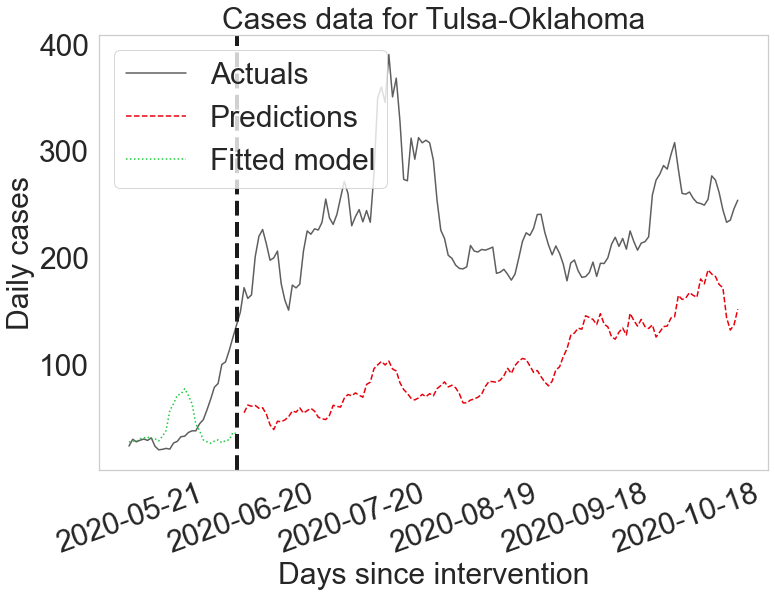

/Users/niloofarbayat/Documents/COVID19-synthetic-control-analysis/synthetic_control_analysis/syn_model.py:302: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=20)


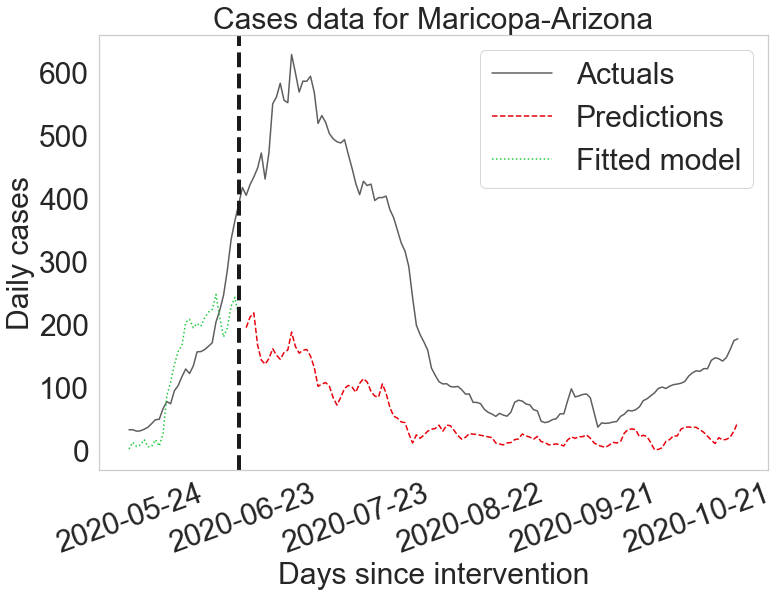

/Users/niloofarbayat/Documents/COVID19-synthetic-control-analysis/synthetic_control_analysis/syn_model.py:302: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=20)


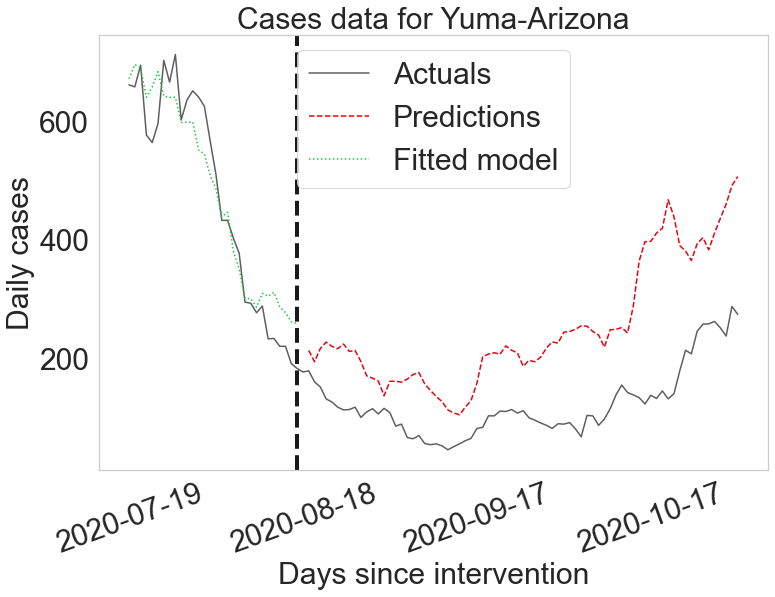

/Users/niloofarbayat/Documents/COVID19-synthetic-control-analysis/synthetic_control_analysis/syn_model.py:302: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=20)


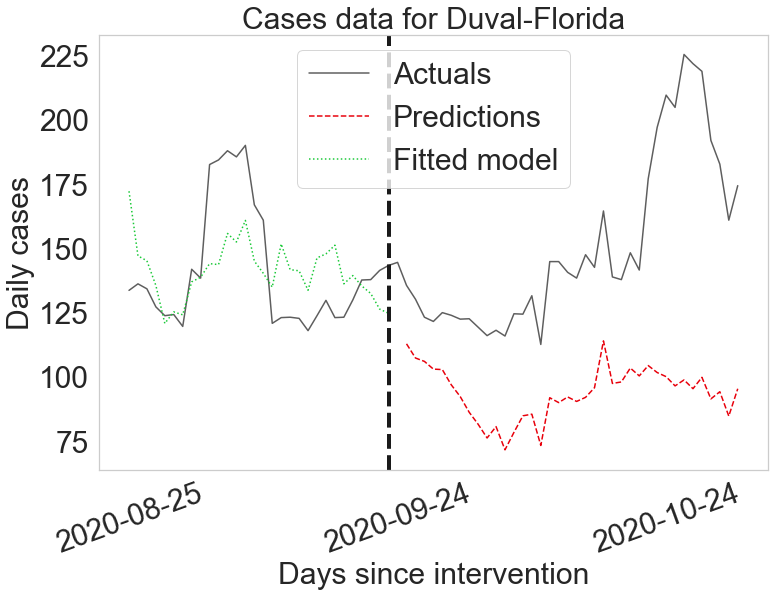

/Users/niloofarbayat/Documents/COVID19-synthetic-control-analysis/synthetic_control_analysis/syn_model.py:302: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=20)


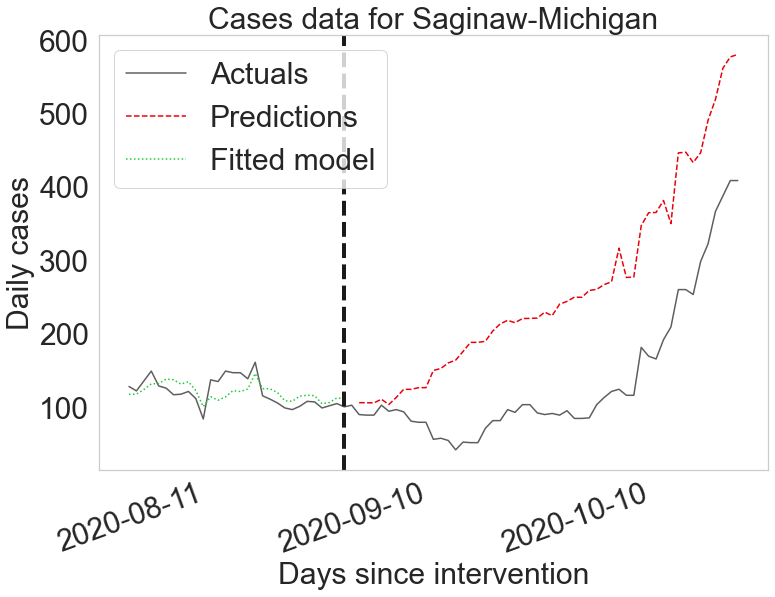

/Users/niloofarbayat/Documents/COVID19-synthetic-control-analysis/synthetic_control_analysis/syn_model.py:302: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=20)


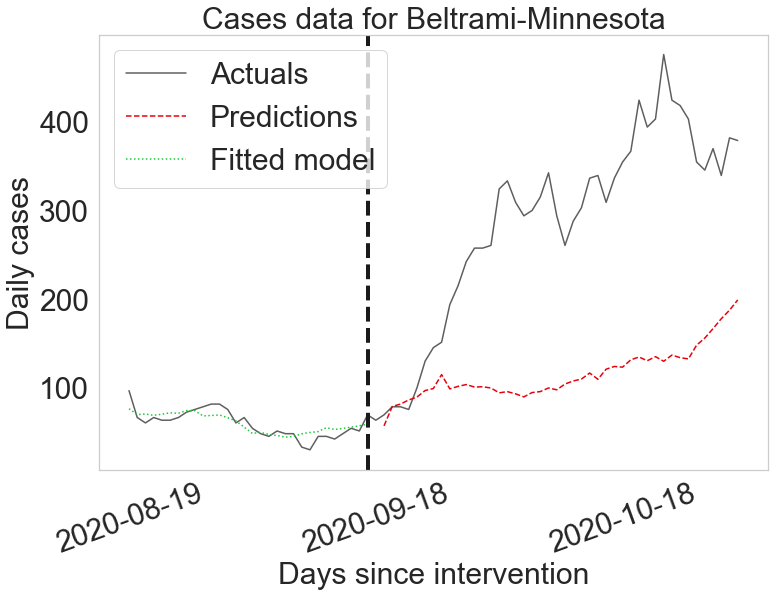

/Users/niloofarbayat/Documents/COVID19-synthetic-control-analysis/synthetic_control_analysis/syn_model.py:302: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=20)


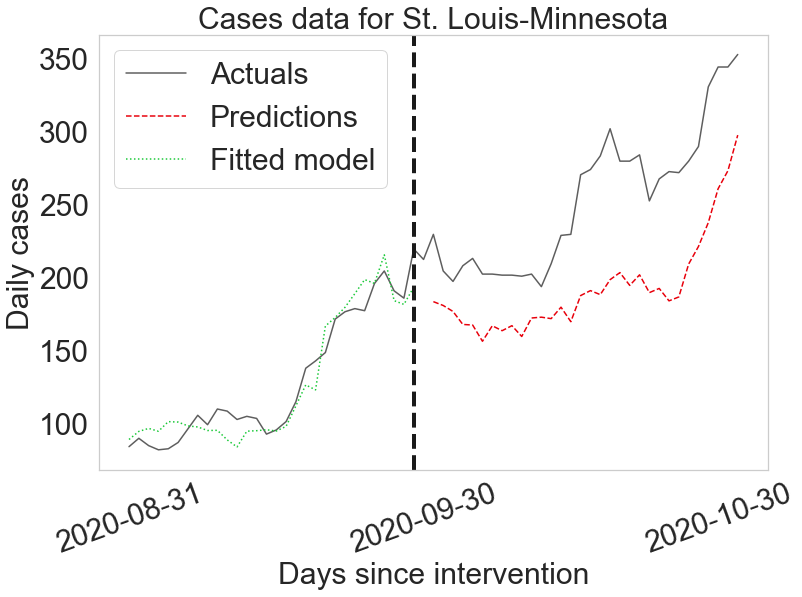

/Users/niloofarbayat/Documents/COVID19-synthetic-control-analysis/synthetic_control_analysis/syn_model.py:302: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=20)


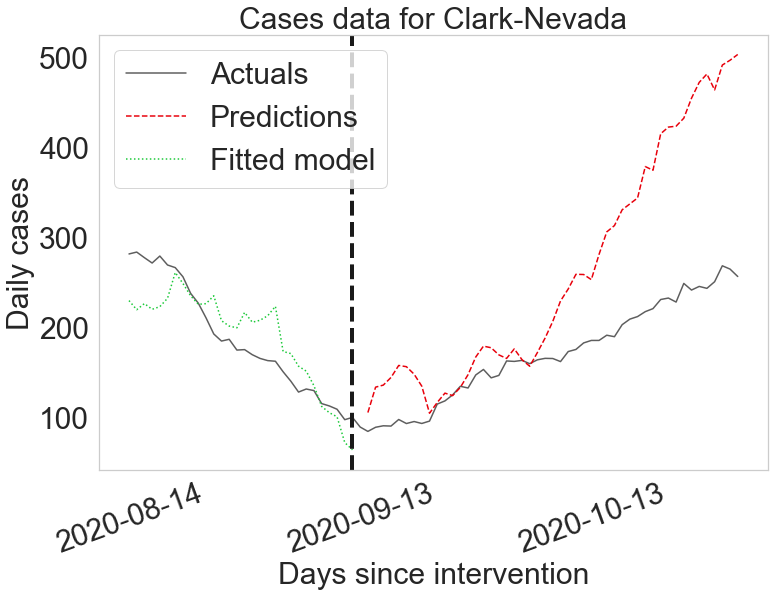

/Users/niloofarbayat/Documents/COVID19-synthetic-control-analysis/synthetic_control_analysis/syn_model.py:302: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=20)


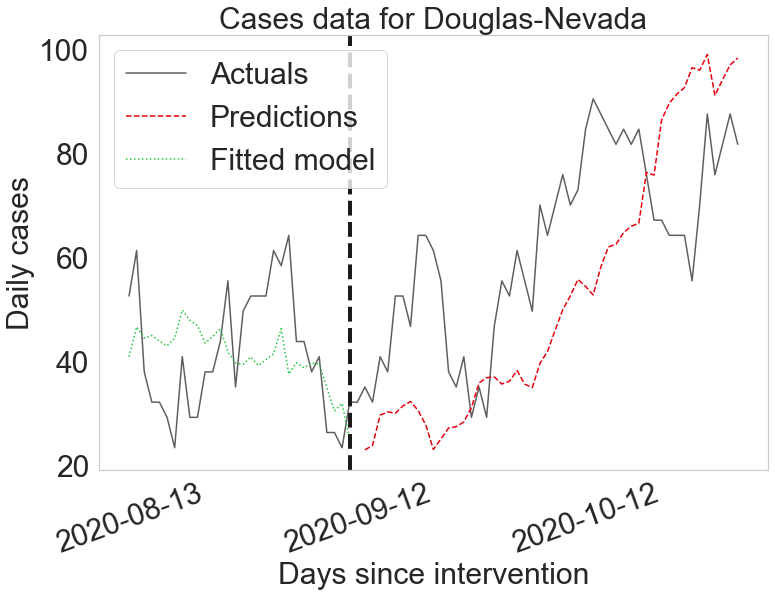

/Users/niloofarbayat/Documents/COVID19-synthetic-control-analysis/synthetic_control_analysis/syn_model.py:302: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=20)


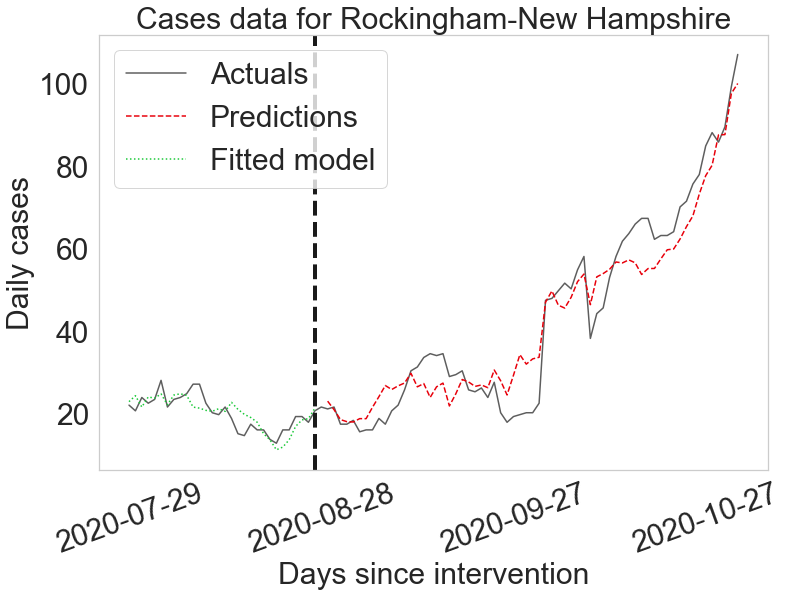

/Users/niloofarbayat/Documents/COVID19-synthetic-control-analysis/synthetic_control_analysis/syn_model.py:302: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=20)


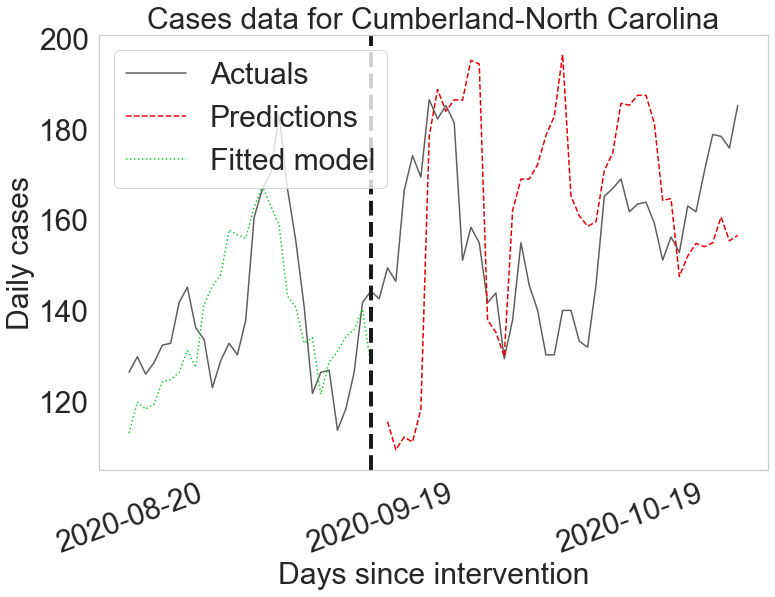

/Users/niloofarbayat/Documents/COVID19-synthetic-control-analysis/synthetic_control_analysis/syn_model.py:302: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=20)


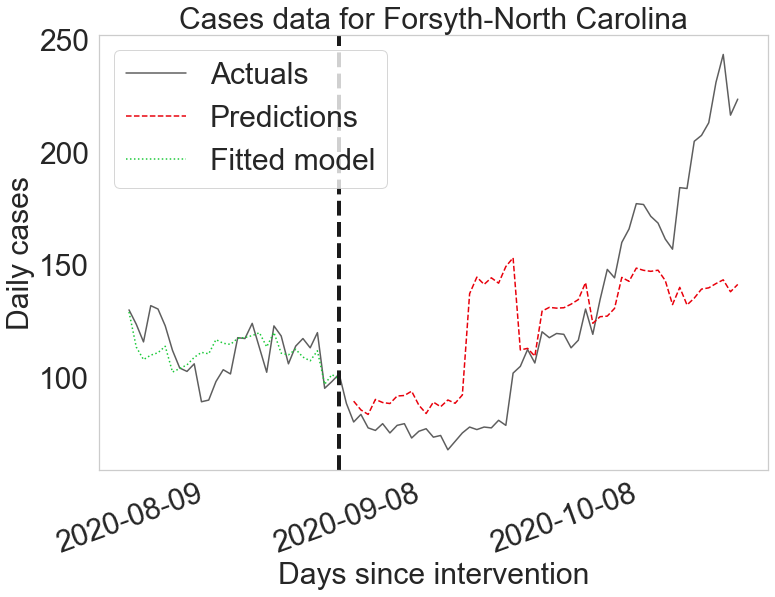

/Users/niloofarbayat/Documents/COVID19-synthetic-control-analysis/synthetic_control_analysis/syn_model.py:302: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=20)


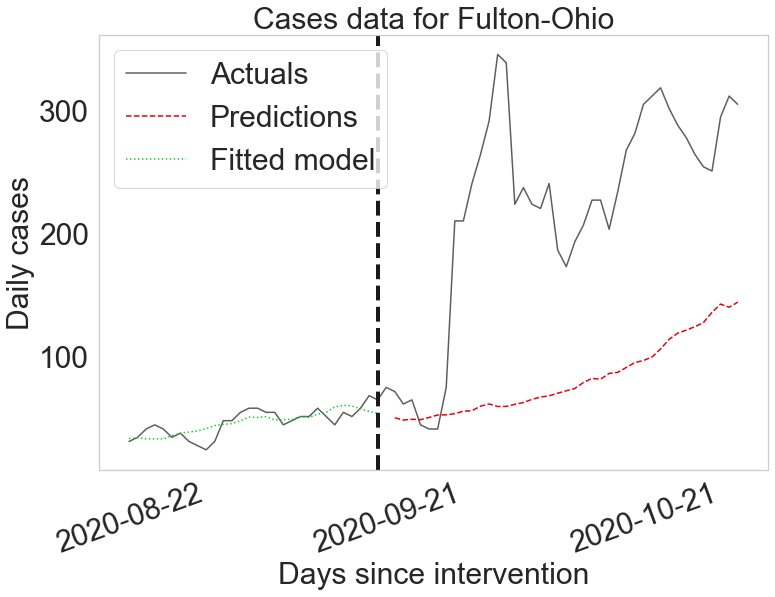

/Users/niloofarbayat/Documents/COVID19-synthetic-control-analysis/synthetic_control_analysis/syn_model.py:302: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=20)


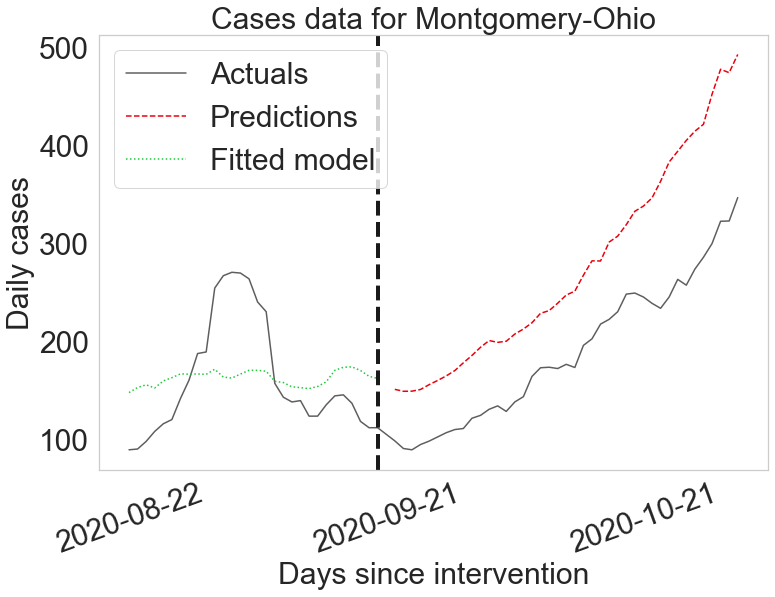

/Users/niloofarbayat/Documents/COVID19-synthetic-control-analysis/synthetic_control_analysis/syn_model.py:302: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=20)


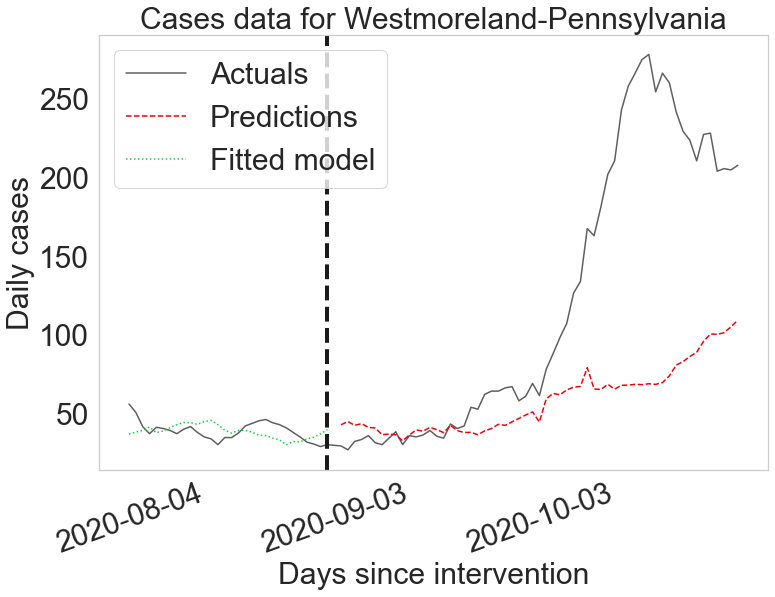

/Users/niloofarbayat/Documents/COVID19-synthetic-control-analysis/synthetic_control_analysis/syn_model.py:302: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=20)


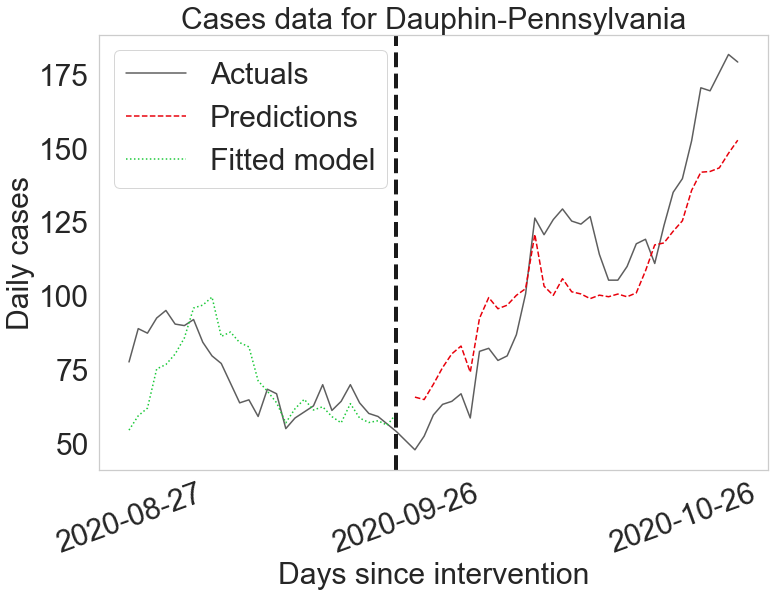

/Users/niloofarbayat/Documents/COVID19-synthetic-control-analysis/synthetic_control_analysis/syn_model.py:302: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=20)


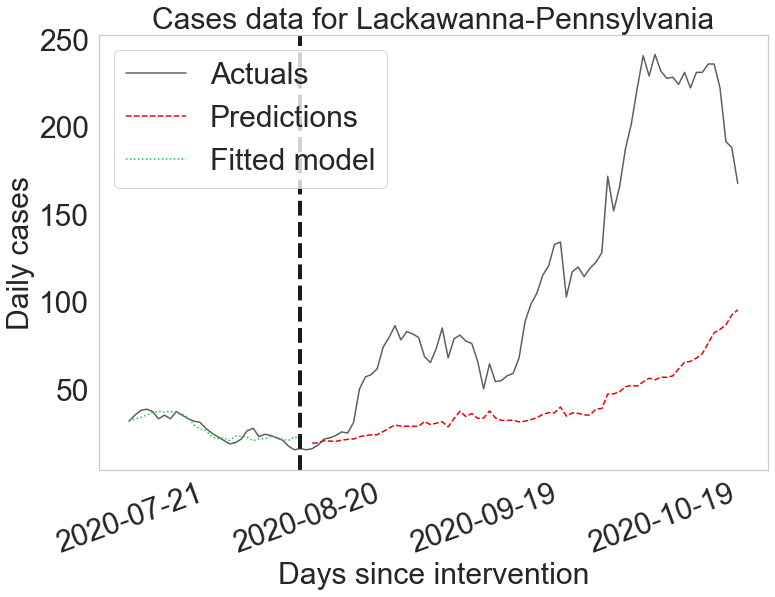

/Users/niloofarbayat/Documents/COVID19-synthetic-control-analysis/synthetic_control_analysis/syn_model.py:302: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=20)


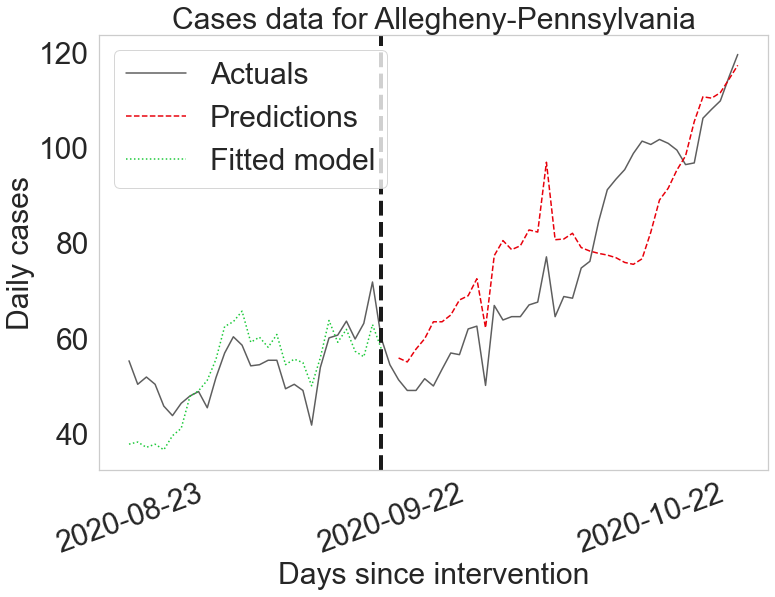

/Users/niloofarbayat/Documents/COVID19-synthetic-control-analysis/synthetic_control_analysis/syn_model.py:302: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=20)


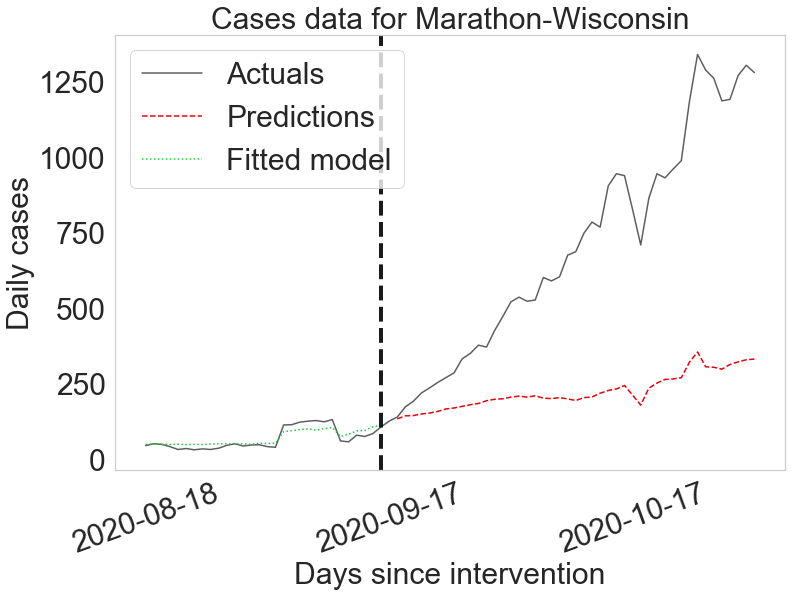

In [72]:
singVals = 2
lambdas = [1, 0.02]
for county_state in county_date_dict.keys():
    fig, axes = plt.subplots(1,1, figsize=(12,8))
    state = county_state.split('-')[1]
    
    donors = []
    for counties in uscounties_cases.columns:
        names = counties.split('-')
        if names[-1] in [state] and names[0] != 'Unknown':
            donors.append(counties)

    low_thresh_date = county_date_dict[county_state]
    start_date = (dt.datetime.strptime(low_thresh_date,'%Y-%m-%d') - dt.timedelta(days = 30)).strftime('%Y-%m-%d')
    df = all_cases_data_pop_daily.loc[start_date:]
    df_pop = all_cases_data_pop.loc[start_date:]
    high_thresh = df_pop.shape[0]
    low_thresh = (pd.to_datetime(low_thresh_date) - pd.to_datetime(start_date)).days
    
    try:

        newdata = synth_control_predictions([df],high_thresh, low_thresh, 
                                            "Cases data", singVals, ylimit=[],xlimit =[], savePlots=True, do_only=[county_state], showstates=4,
                               exclude=list(county_date_dict.keys()), figure=fig, axes=axes, donorPool=donors, 
                                    svdSpectrum=False, silent=True, showDonors=False, showPlots=True, lambdas=lambdas, mRSC=False, error_thresh=4634, FONTSIZE=30, yaxis = 'Daily cases')
    except:
        continue
    '''
    
    rscModel = syn_model(county_state, singVals, [df], high_thresh, low_thresh, otherStates=donors)
    rscModel.fit_model()

    perm_dict = rscModel.permutation_distribution(show_graph = False)
    perm_dict.pop(county_state) 
    selected = np.array(list(perm_dict.values()))
    new_donor = list(np.array(list(perm_dict.keys()))[selected < c])
    print('c:',c,'\n Singvals:',rscModel.kSingularValues,'\n permutation:',selected,'\n old donors:', donors, '\n new donors:',new_donor)

    new_model = syn_model(rscModel.state,  rscModel.kSingularValues, [df], high_thresh, low_thresh, otherStates=new_donor)
    new_model.fit_model()
    new_model.plot(figure=fig, axes=axes, title_text="Deaths data", ylimit=[], xlimit=[0,120], logy=False, show_donors=True, tick_spacing=30, yaxis="Daily deaths", intervention_date_x_ticks=None, fontsize = FONTSIZE)

    #plt.savefig("../Figures/COVID/deaths_NY.pdf",bbox_inches='tight')    

    '''
    